# Inferring from Weather data

In this homework, we are going back to Weather data again. The main task of the homework is to do the spectral analysis of TAVG measurements in India.

In [1]:
country = 'India'
meas = 'TAVG'

## Part 0: Loading libraries and data

In [2]:
%pylab inline

import pandas as pd
import numpy as np

from lib.numpy_pack import unpackArray, unpackAndScale
from lib.YearPlotter import YearPlotter
from lib.decomposer import decompose_dataframe, Eigen_decomp
from lib.Reconstruction_plots import plot_recon_grid, recon_plot

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [4]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)

In [5]:
## load measurement and stations dataframe
parquet_root = './resource/asnlib/publicdata/'

weather_path = os.path.join(parquet_root, 'weather-{}-{}.parquet'.format(country, meas))
weather = sqlContext.read.parquet(weather_path)
sqlContext.registerDataFrameAsTable(weather, 'weather')
print('weather is a Dataframe (and table) which is a join of measurements and stations with %d records'%(weather.count()))

weather is a Dataframe (and table) which is a join of measurements and stations with 4811 records


In [6]:
import pickle 

ms = []
pkl_filename = os.path.join(parquet_root, "%s-TMAX,TMIN,TAVG.pkl"%(country))
with open(pkl_filename,'br') as pkl_file:
    STAT = pickle.load(pkl_file)

## Part 1: Exploring the PCA decomposition

In this section, we want to construct approximations of TAVG measurements in India using the mean and the 2 top eigenvectors. **Each TAVG measurement is a list of average temperature values measured in a weather station for all days (366 days) in a year.**

- `EigVec` is a matrix of shape (366, 2), in which each column is an eigenvector of all the TAVG measurements in India.
- `Mean` is a vector of length 366 that has the average TAVG measurements across all stations in India. 

In [7]:
k = 2
EigVec = np.array(STAT[meas]['eigvec'][:,:k])
Mean = STAT[meas]['Mean']

First we want to plot the mean and the 2 top eigenvectors as functions of time (days of a year).

In [22]:
EigVec

array([[ 8.95292578e-02,  3.87611085e-02],
       [ 8.96516218e-02,  3.65613972e-02],
       [ 9.04664339e-02,  3.99611838e-02],
       [ 9.07494977e-02,  4.47866222e-02],
       [ 9.02948944e-02,  4.37264432e-02],
       [ 8.99733107e-02,  4.41263812e-02],
       [ 8.99144747e-02,  5.22115824e-02],
       [ 8.87475259e-02,  5.46362290e-02],
       [ 8.94092598e-02,  5.10009550e-02],
       [ 8.80029593e-02,  4.48322468e-02],
       [ 9.01713545e-02,  4.44861469e-02],
       [ 8.97750675e-02,  3.56520916e-02],
       [ 9.14255803e-02,  2.79031946e-02],
       [ 9.14445135e-02,  3.02300067e-02],
       [ 9.03218642e-02,  3.46828973e-02],
       [ 8.99962569e-02,  2.85501967e-02],
       [ 9.03251561e-02,  3.90926343e-02],
       [ 9.06826904e-02,  3.21441031e-02],
       [ 9.07260433e-02,  4.09279912e-02],
       [ 8.69500430e-02,  4.54273489e-02],
       [ 8.85514835e-02,  4.35779128e-02],
       [ 8.82425751e-02,  4.29136344e-02],
       [ 9.00780912e-02,  3.17930252e-02],
       [ 9.

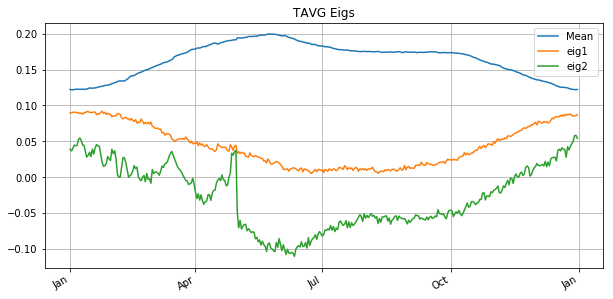

In [8]:
_norm_Mean = Mean / max(Mean) * 0.2 # Combine mean with Eigvecs and scale to similar range.
A = [_norm_Mean] + [EigVec[:,i] for i in range(EigVec.shape[1])]
Combined = np.stack(A).transpose()
fig, axes = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5)); 

YearPlotter().plot(Combined, fig, axes, title=meas+' Eigs', labels=['Mean'] + ['eig'+str(i+1) for i in range(k)])

### Problem 1

Given that all the eigenvalues are stored in `eigvals`, plot the percentage of the variance explained by the first 9 eigenvectors. The resulting graph should look like this:
![Problem 1](figs/prob1.png "Percentage of variance explained")
Note that the graph shows **10** points instead of 9, since it includes the percentage of the variance explained by 0 eigenvector.

#### Task:

Calculate the numpy array `cumvar_10`.The element of `cumvar_10` on index $i$ is the percentage of the variance explained by the first $i$ eigenvectors. **Note that each value in `cumvar_10` should be a value from 0 to 100.** Check the correctness of your solution by comparing your graph with the graph shown above. 

You may ignore the fact that some eigenvalues are negative, which may be caused by the numerical errors induced by nan values. You should just treat them as normal eigenvalues and should NOT manually make them positive. Also, you don't have to sort `eigvals` as the first 10 values in `eigvals` are already sorted according to their magnitude. 

In [24]:
import sys

size = sys.getsizeof(eigvals)

size

136

In [26]:
eigvals[:10]

TypeError: 'function' object is not subscriptable

In [ ]:
mse = np.mean((eigvals[:10] - EigVec[:10])**2)

In [ ]:
dec = (np.cumsum(eigvals) / np.sum(eigvals))*100
dec[:10]

In [ ]:
dec[0]

In [ ]:
cumvar_101 = np.concatenate(([0], dec[:9]))
cumvar_101

NameError: name 'cumvar_101' is not defined

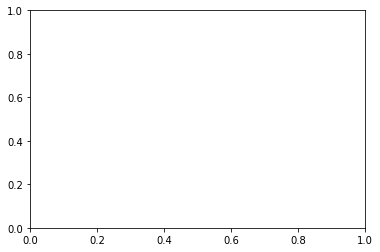

In [8]:
fig,ax=plt.subplots(1,1);
ax.plot(cumvar_101); 
ax.grid(); 
ax.set_ylabel('Percentage of variance explained')
ax.set_xlabel('Number of eigenvectors')
ax.set_ylim([0,100])
ax.set_title('Percentage of variance explained');

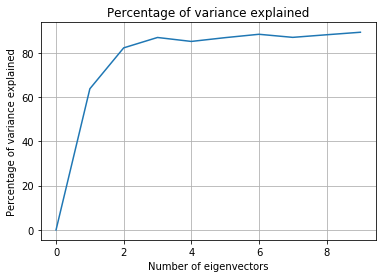

In [129]:
eigvals = STAT[meas]['eigval']

###
### YOUR CODE HERE
###

cumvar_10 = (np.cumsum(eigvals) / np.sum(eigvals))*100
cumvar_10 = np.concatenate(([0], cumvar_10[:9]))

cumvar_10 = np.array(cumvar_10[:10])
fig,ax=plt.subplots(1,1);
ax.plot(cumvar_10); 
ax.grid(); 
ax.set_ylabel('Percentage of variance explained')
ax.set_xlabel('Number of eigenvectors')
ax.set_title('Percentage of variance explained');

In [130]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Here we construct a Spark DataFrame `df2`, in which each row is a TAVG measurement from a weather station in India. We will be focusing on these columns of `df2` in this notebook:

- `Values`: the TAVG temperature measurement, which is a list of the average temperatures for 366 days in a year (encoded in a byte array).
- `coeff_[i]`: the projection coefficient in front of the `[i]`th eigenvector in the eigen-decomposition of `Values`.
- `res_[i]`: the normalized residual norm of the approximation using the top `[i]` eigenvector.
- `Station`: the id of the station from which the measurement was collected.
- `latitude`, `longitude`: the latitude and longitude of the station.

In [10]:
Query="""
select *
from weather
WHERE country='%s' and measurement='%s'
""" % (country, meas)
df = sqlContext.sql(Query)

df2 = decompose_dataframe(sqlContext, df, EigVec, Mean).cache()
df2.toPandas().head()

Measurement      Station                                             Values  \
0        TAVG  IN017121000  [184, 0, 187, 0, 181, 0, 207, 0, 203, 0, 187, ...   
1        TAVG  IN024059900  [25, 252, 25, 252, 25, 252, 25, 252, 25, 252, ...   
2        TAVG  IN008040500  [97, 0, 115, 0, 124, 0, 120, 0, 104, 0, 103, 0...   
3        TAVG  IN023420800  [39, 0, 17, 0, 32, 0, 17, 0, 29, 0, 38, 0, 25,...   
4        TAVG  IN006031000  [123, 0, 144, 0, 81, 0, 104, 0, 135, 0, 131, 0...   

   Year      coeff_1     coeff_2 country  dist2coast  elevation  latitude  \
0  2020   131.490175  -95.774324   India      286.25      230.0    21.917   
1  2020     6.822229  -15.822153   India      487.75      131.0    26.633   
2  2020 -1002.484684 -187.368935   India     1127.00      367.0    32.667   
3  2020 -1764.473492  881.425849   India     1045.00     2311.0    29.467   
4  2019  -755.542637 -500.901593   India      817.00      221.0    29.167   

   longitude               name     res_1     res_2  res_mean state  \
0     84.083         JHARSUGUDA  0.900244  0.847321  0.006377         
1     88.317           SILIGURI  0.997147  0.984403  0.004200         
2     74.833              JAMMU  0.185366  0.156908  0.061604         
3     79.650  MUKTESHWAR KUMAON  0.274541  0.113426  0.507652         
4     75.733             HISSAR  0.458276  0.216608  0.044107         

    total_var  
0  27177476.0  
1   7588012.0  
2  20025644.0  
3   9150026.0  
4  24094505.0

Then we will study what information `coeff_1` and `coeff_2` can tell us.

For each coefficient, 

1. We first filter out the rows where the approximation residuals are too large.
1. Then we sort the rows according to the coefficient values in the increasing order.
1. Last we plot the rows that have the lowest and highest coefficient values. 

Each figure below plots the approximations of each measurement (each row in `df2`). 

- `mean`: the `Mean` variable.
- `target`: the `Values` field of the measurement. 
- `approx [i]`: the approximation using the first `[i]` eigenvectors. 
- `c[i]`, `r[i]`: the values of `coeff_[i]`, `res_[i]`.

In [11]:
# Filter and sort according to coeff_1
coeff1_rows = df2.filter(df2.res_1 < 0.3).sort(df2.coeff_1).collect()

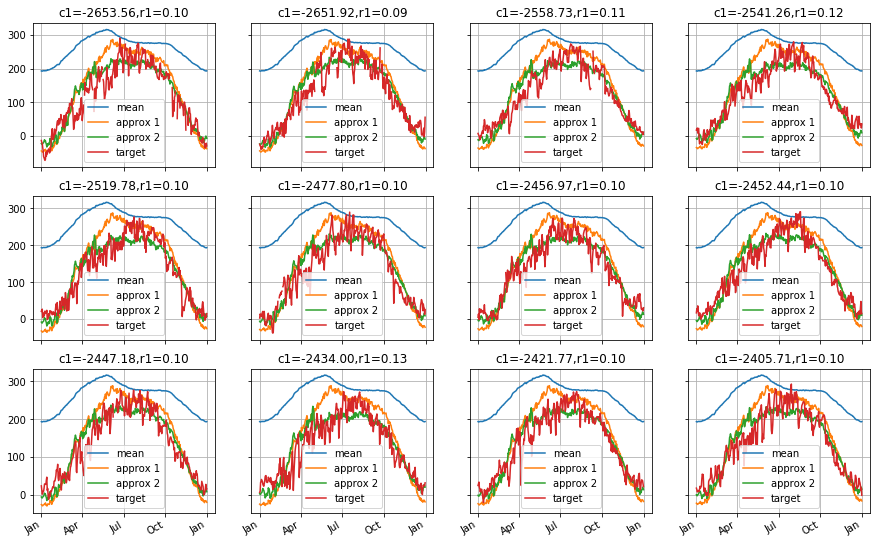

In [12]:
# Measurements with lowest 12 coeff_1
plot_recon_grid(coeff1_rows[0:12], Mean, EigVec, header='c1=%3.2f,r1=%3.2f', params=('coeff_1','res_1'))

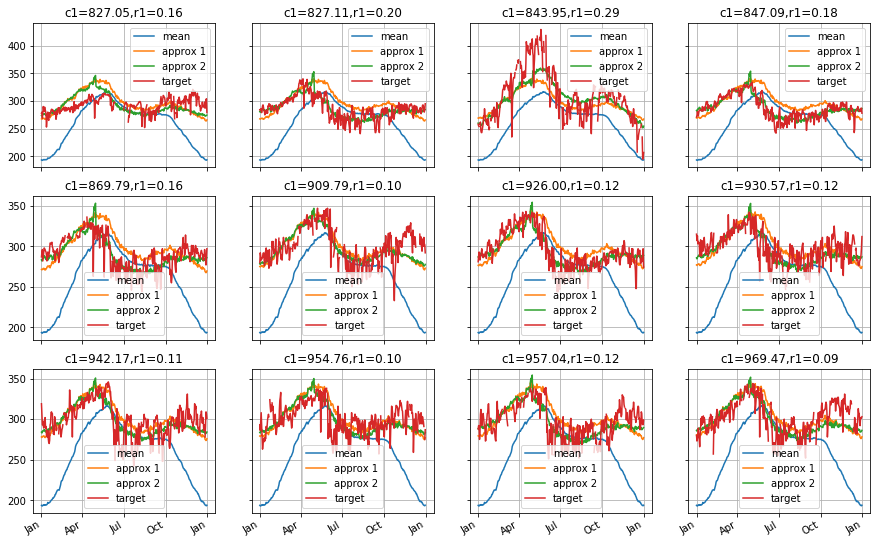

In [13]:
# Measurements with highest 12 coeff_1
plot_recon_grid(coeff1_rows[-12:], Mean, EigVec, header='c1=%3.2f,r1=%3.2f', params=('coeff_1','res_1'))

### Problem 2

The following problems ask you to derive information from the 2 figures shown above. You should be able to answer these questions just by looking at the figures. 


#### Task:

Answer the 4 questions below. Put your answers into the corresponding variables in the next cell.

1. (`answer2_1`) What is the month with the highest average temperature over all stations?

    1. February 
    
    1. Apil
    
    1. June
    
    1. August
    
    1. October
    
1. (`answer2_2`) What are the three months with almost the same average temperature over all stations?

    1. January, February, and March
    
    1. Apirl, Augest, and Septermper
    
    1. March, November, and December
    
    1. January, June, and December
    
1. (`answer2_3`) What is the relation between the value of the first coefficient (`c1`) and the value of averaging the TAVG (`target`) over the year?

    1. Correlated
    
    1. Anticorrelated
    
    1. Uncorrelated
    
1. (`answer2_4`) What is the relation between the value of the first coefficient (`c1`) and the absolute difference of the TAVG (`target`) between winter and summer?

    1. Correlated
    
    1. Anticorrelated
    
    1. Uncorrelated
    
    
**Hint:**

- We say two quantities are correlated when one quantity increases (decreases) and the other increases (decreases).
- We say two quantities are anticorrelated when one quantity increases (decreases) and the other decreases (increases).
- We say two quantities are uncorrelated when there is no obvious relation between them.

In [131]:
# THIS IS JUST A TEMPLATE. COPY THE VARIABLES AND CHANGE THE VALUES. DO NOT CHANGE VARIABLE NAMES!
answer2_1 = 'A'
answer2_2 = 'B'
answer2_3 = 'C'
answer2_4 = 'D'

###
### YOUR CODE HERE
###

answer2_1 = 'C'
answer2_2 = 'B'
answer2_3 = 'A'
answer2_4 = 'B'

In [132]:
answers = ['A', 'B', 'C', 'D', 'E']
assert answer2_1 in answers, 'answer2_1 should be one of {}'.format(answers)

answers = ['A', 'B', 'C', 'D']
assert answer2_2 in answers, 'answer2_2 should be one of {}'.format(answers)

answers = ['A', 'B', 'C']
assert answer2_3 in answers, 'answer2_3 should be one of {}'.format(answers)

answers = ['A', 'B', 'C']
assert answer2_4 in answers, 'answer2_4 should be one of {}'.format(answers)

In [133]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [134]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [135]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [136]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [20]:
# Filter and sort according to coeff_2
coeff2_rows = df2.filter(df2.res_2 < 0.11).filter(df2.res_1 > 0.2).sort(df2.coeff_2).collect()

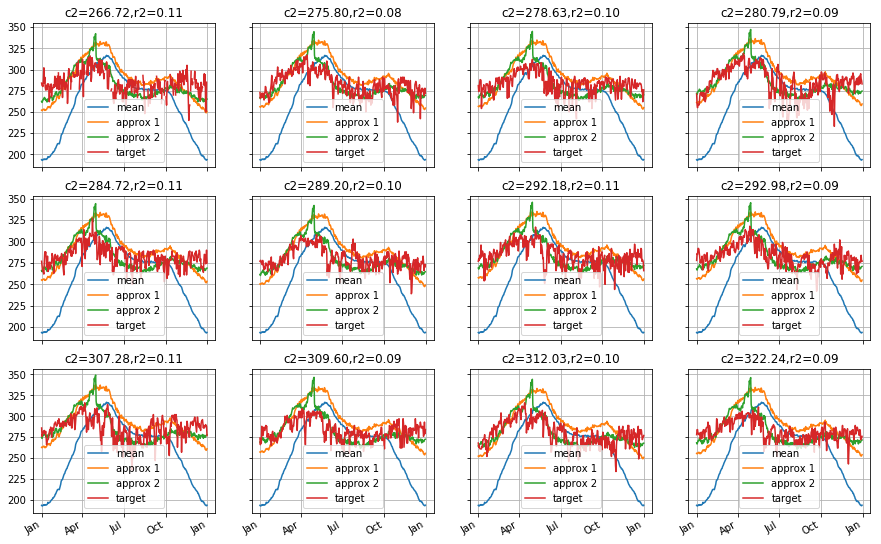

In [21]:
# Measurements with lowest 12 coeff_2
plot_recon_grid(coeff2_rows[0:12], Mean, EigVec, header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

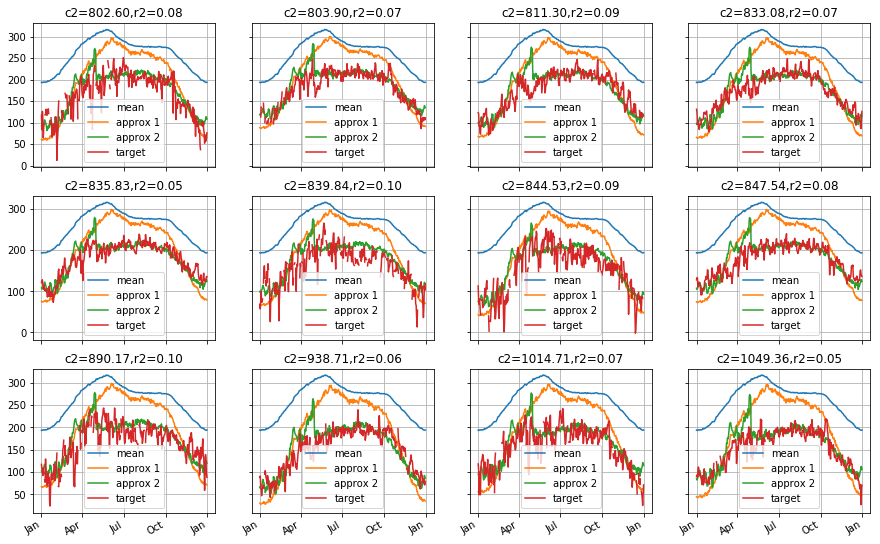

In [22]:
# Measurements with highest 12 coeff_2
plot_recon_grid(coeff2_rows[-12:], Mean, EigVec, header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

### Problem 3

The following problems ask you to derive information from the 2 figures shown above. You should be able to answer these questions just by looking at the figures. 

#### Task:

Answer the 2 questions below. Put your answers into the corresponding variables in the next cell.

1. (`answer3_1`) What is the relation between the winter temperature and the summer temperature when coefficient 2 (`c2`) is > 800?

    1. The winter temperature is usually higher than the summer temperature
    
    1. The winter temperature is usually lower than the summer temperature
    
    1. The winter temperature is usually similar to the summer temperature
    
1. (`answer3_2`) What is the relation between the winter temperature and the summer temperature when coefficient 2 (`c2`) is < 350?

    1. The winter temperature is usually higher than the summer temperature
    
    1. The winter temperature is usually lower than the summer temperature
    
    1. The winter temperature is usually similar to the summer temperature

In [137]:
# THIS IS JUST A TEMPLATE. COPY THE VARIABLES AND CHANGE THE VALUES. DO NOT CHANGE VARIABLE NAMES!
answer3_1 = 'A'
answer3_2 = 'B'

###
### YOUR CODE HERE
###

answer3_1 = 'B'
answer3_2 = 'C'

In [138]:
answers = ['A', 'B', 'C']
assert answer3_1 in answers, 'answer3_1 should be one of {}'.format(answers)

answers = ['A', 'B', 'C']
assert answer3_2 in answers, 'answer3_2 should be one of {}'.format(answers)

In [139]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [140]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Instead of plotting the measurements with lowest and highest coefficients, we can just visualize any measurement and its approximations in an interactive plot, where the different approximations can be seen by manually changing the projection coefficients.

In [141]:
# Here we select the measurement (row) with highest `coeff_2`.
row = coeff2_rows[-1]

target = np.array(unpackArray(row.Values, np.int16), dtype=np.float64)
eigen_decomp = Eigen_decomp(None, target, Mean, EigVec)
total_var, residuals, coeff = eigen_decomp.compute_var_explained()
res = residuals[1]
print('residual normalized norm  after mean:', res[0])
print('residual normalized norm  after mean + top eigs:', res[:])

plotter = recon_plot(eigen_decomp, year_axis=True, interactive=True)
display(plotter.get_Interactive())

residual normalized norm  after mean: 0.48807580115566984
residual normalized norm  after mean + top eigs: [0.4880758  0.30144218 0.05103543]


VBox(children=(HBox(children=(FloatSlider(value=0.0, description='c0', max=0.0, min=-1664.5074436452255, orientation='vertical', step=166.45074436452256), FloatSlider(value=0.0, description='c1', max=1049.361487524602, orientation='vertical', step=104.93614875246018))), Output()))

### Problem 4

The following problem asks you to play with the interactive plot to see what will happen. You should be able to answer these questions just by changing the sliders for `c0` and `c1`. 

#### Task:

Answer the question below. Put your answers into the corresponding variables in the next cell.

1. What are the values of `c0` and `c1` that can recreate the graph shown below?

![Problem 4](figs/prob4.png "Expected graph for Problem 4")

In [142]:
# THIS IS JUST A TEMPLATE. COPY THE VARIABLES AND CHANGE THE VALUES. DO NOT CHANGE VARIABLE NAMES!
c0 = 100.0
c1 = 200.0

###
### YOUR CODE HERE
###

c0 = -1165.61
c1 = 1049.36

In [143]:
assert type(c0) == float, 'c0 should be a float number'
assert type(c1) == float, 'c1 should be a float number'

In [144]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [145]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


## Part 2: Partitioning the `coeff_1`, `coeff_2` plane 

If we view `coeff_1` as the x-axis and `coeff_2` as the y-axis, we can find that the distribution of the coefficients of the first 2 eigenvectors in `df2` shows some clusters. In this section, we will analyze the coefficients by grouping them together.

First, we define 7 clusters and manually choose the centers for these clusters. In each center, the first element defines the center for `coeff_1` and the second element defines the center for `coeff_2`. 

In [146]:
centers = {
    '0': (0, 0),
    '1': (-250, -250),
    '2': (500, 0),
    '3': (500, 400),
    '4': (-100, 600),
    '5': (-1500, 500),
    '6': (-200, 100)
}

C = []
for key in centers:     
    C.append(centers[key])
C = stack(C)

### Problem 5

Here we are doing several things that are useful later:

1. Convert `df2` to `df3` by grouping the measurements that are from the same `Station`. Each row of `df3` is a station with its `Station`, `Longitude`, `Latitude` and average values of `coeff_1`, and `coeff_2` of the measurements from the station.
1. Count the number of measurements for each `Station` and store the results in `station_counts`.
1. Get `pdf` by merging (join) `df3` and `station_counts` on column `Station`.

Note that `pdf` is a pandas DataFrame instead of Spark DataFrame to allow less constrained queries.

#### Task:

Write the code that converts `df2` to `df3` (first point above). 
- The `coeff_1` and `coeff_2` columns are grouped by taking the average.
- The `Longitude` and `Latitude` columns are grouped by taking the average or selecting any of them since the same `Station` will have the same `Longitude` and `Latitude`.
- The rest of the columns in `df2` are discarded.
- `df3` should have 5 columns: `Station`, `coeff_1`, `coeff_2`, `Longitude`, and `Latitude`. Although your solution doesn't have to have the exact same column names, **you should have the same column order** (1st column is stations, 2nd column and 3rd column are the average coeff_1 and coeff_2 values, and 4th and 5th columns are longitudes and latitudes.) 
- The order of the rows in `df3` doesn't matter.
- You should use Spark DataFrame API instead of pandas DataFrame API for this task.

Hints:
1. Use [`groupBy`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.groupBy.html).

In [36]:
df2.toPandas().head()

Measurement      Station                                             Values  \
0        TAVG  IN017121000  [184, 0, 187, 0, 181, 0, 207, 0, 203, 0, 187, ...   
1        TAVG  IN024059900  [25, 252, 25, 252, 25, 252, 25, 252, 25, 252, ...   
2        TAVG  IN008040500  [97, 0, 115, 0, 124, 0, 120, 0, 104, 0, 103, 0...   
3        TAVG  IN023420800  [39, 0, 17, 0, 32, 0, 17, 0, 29, 0, 38, 0, 25,...   
4        TAVG  IN006031000  [123, 0, 144, 0, 81, 0, 104, 0, 135, 0, 131, 0...   

   Year      coeff_1     coeff_2 country  dist2coast  elevation  latitude  \
0  2020   131.490175  -95.774324   India      286.25      230.0    21.917   
1  2020     6.822229  -15.822153   India      487.75      131.0    26.633   
2  2020 -1002.484684 -187.368935   India     1127.00      367.0    32.667   
3  2020 -1764.473492  881.425849   India     1045.00     2311.0    29.467   
4  2019  -755.542637 -500.901593   India      817.00      221.0    29.167   

   longitude               name     res_1     res_2  res_mean state  \
0     84.083         JHARSUGUDA  0.900244  0.847321  0.006377         
1     88.317           SILIGURI  0.997147  0.984403  0.004200         
2     74.833              JAMMU  0.185366  0.156908  0.061604         
3     79.650  MUKTESHWAR KUMAON  0.274541  0.113426  0.507652         
4     75.733             HISSAR  0.458276  0.216608  0.044107         

    total_var  
0  27177476.0  
1   7588012.0  
2  20025644.0  
3   9150026.0  
4  24094505.0

In [44]:
df2.printSchema()

root
 |-- Measurement: string (nullable = true)
 |-- Station: string (nullable = true)
 |-- Values: binary (nullable = true)
 |-- Year: long (nullable = true)
 |-- coeff_1: double (nullable = true)
 |-- coeff_2: double (nullable = true)
 |-- country: string (nullable = true)
 |-- dist2coast: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- res_1: double (nullable = true)
 |-- res_2: double (nullable = true)
 |-- res_mean: double (nullable = true)
 |-- state: string (nullable = true)
 |-- total_var: double (nullable = true)



In [50]:
grouped = df2.groupBy("Station")\
        .agg(avg("coeff_1").alias("coeff_1"), avg("coeff_2").alias("coeff_2"))

lat_long = df2.groupBy("Station")\
        .agg(avg("longitude").alias("longitude"), avg("latitude").alias("latitude"))
    
df3 = grouped.join(lat_long, "Station").select("Station", "coeff_1", "coeff_2", "longitude", "latitude")

In [51]:
df3.toPandas().head()

Station     coeff_1     coeff_2  longitude  latitude
0  IN019010300 -187.897968 -246.619623     74.617    26.450
1  IN012180300    4.340698    0.985582     76.833    19.133
2  IN024080100   30.338100  -20.879605     88.717    26.533
3  IN009100200  131.707617   28.898726     76.850    17.350
4  IN012131800  148.238859  170.407617     74.233    16.700

In [53]:
from pyspark.sql.functions import avg

df3 = df2.groupBy("Station")\
        .agg(avg("coeff_1").alias("coeff_1"), avg("coeff_2").alias("coeff_2"))\
        .select("Station", "coeff_1", "coeff_2", "latitude", "longitude")

AnalysisException: "cannot resolve '`latitude`' given input columns: [Station, coeff_1, coeff_2];;\n'Project [Station#50, coeff_1#1712, coeff_2#1714, 'latitude, 'longitude]\n+- AnalysisBarrier\n      +- Aggregate [Station#50], [Station#50, avg(coeff_1#53) AS coeff_1#1712, avg(coeff_2#54) AS coeff_2#1714]\n         +- LogicalRDD [Measurement#49, Station#50, Values#51, Year#52L, coeff_1#53, coeff_2#54, country#55, dist2coast#56, elevation#57, latitude#58, longitude#59, name#60, res_1#61, res_2#62, res_mean#63, state#64, total_var#65], false\n"

In [147]:
###
### YOUR CODE HERE
###

from pyspark.sql.functions import avg

grouped = df2.groupBy("Station")\
        .agg(avg("coeff_1").alias("coeff_1"), avg("coeff_2").alias("coeff_2"))

lat_long = df2.groupBy("Station")\
        .agg(avg("longitude").alias("longitude"), avg("latitude").alias("latitude"))
    
df3 = grouped.join(lat_long, "Station").select("Station", "coeff_1", "coeff_2", "longitude", "latitude")

pdf3 = df3.toPandas().sort_values('Station')
station_counts = df2.groupBy('Station').count()
pdf = pdf3.merge(station_counts.toPandas(), on='Station')
print(f'There are in total {pdf.shape[0]} stations')

# Assign shorter names to the columns
pdf.columns=['Station', 'coeff_1', 'coeff_2', 'Longitude', 'Latitude', 'count']
pdf.head()

There are in total 183 stations


Station     coeff_1     coeff_2  Longitude  Latitude  count
0  IN001020700  501.828895   56.073761     77.633    14.583     52
1  IN001050200  440.247446  -10.410478     82.233    16.950     50
2  IN001080500  269.624439  135.317346     78.470    17.450     54
3  IN001090500  318.556718  -95.619204     79.433    18.767     49
4  IN001111200  428.893895  -43.875230     81.150    16.200     50

In [148]:
test = df3.toPandas().sort_values('Station').values
answer = np.array([
    ['IN001020700', 501.8288947351339, 56.073760669096956, 77.63299999999998, 14.583],
    ['IN001050200', 440.2474457975864, -10.410478399340107, 82.23299999999999, 16.95],
    ['IN001080500', 269.6244393741326, 135.31734576445672, 78.46999999999997, 17.450000000000006],
    ['IN001090500', 318.55671843948204, -95.6192036324071, 79.433, 18.767000000000003],
    ['IN001111200', 428.89389515464353, -43.875230463056795, 81.15000000000002, 16.200000000000003]
])


assert test.shape == (183, 5)
assert (test[:5, 0] == answer[:5, 0]).all(), 'Your answer is not correct'
assert np.isclose(test[:5, 1:].astype(float), answer[:5, 1:].astype(float), rtol=0, atol=1e-1).all(), 'Your answer is not correct'

In [149]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### Problem 6

In this cell, we want to group the stations to their closest center that we defined earlier and add their groups to `pdf` DataFrame.

#### Task:

Given `coeffs`, in which each row contains the `(coeff_1, coeff_2)` of each station, find the index of centers in numpy array `C` that is closest (minimum euclidean distance) to the `(coeff_1, coeff_2)` of each station. Store the results in variable `group`, in which the value in index `i` is the index of the nearest center for `Station i` in `pdf`. 

Hints:
1. Use [`cdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) to calculate the euclidean distance.
1. The best implementation should have only 2 lines of code. 
    1. Calculate the euclidean distances.
    1. Select the center with the minimized euclidean distance for each station.

In [60]:
from scipy.spatial.distance import cdist

coeffs = np.array(pdf[['coeff_1','coeff_2']])

coeffs

array([[ 5.01828895e+02,  5.60737607e+01],
       [ 4.40247446e+02, -1.04104784e+01],
       [ 2.69624439e+02,  1.35317346e+02],
       [ 3.18556718e+02, -9.56192036e+01],
       [ 4.28893895e+02, -4.38752305e+01],
       [ 2.49850527e+02, -3.44119074e+01],
       [ 5.31836432e+02,  1.23118287e+01],
       [ 5.33433566e+02, -1.63103259e+02],
       [ 4.67239209e+02, -4.45753734e+01],
       [ 2.58505523e+02,  2.90760191e+01],
       [ 3.50333431e+02, -1.22865084e+01],
       [-1.89289499e+02,  1.05038757e+02],
       [-1.70129511e+01,  1.15916603e+00],
       [-1.89146340e+02,  7.16708083e+01],
       [-2.28220814e+02,  5.27968081e+01],
       [-1.00764910e+01,  6.26929874e+00],
       [ 3.47635902e+00, -1.64962672e+01],
       [-3.24465059e+02,  5.19652520e+01],
       [-4.97009197e+02,  1.80932328e+02],
       [-2.30524764e+02,  5.29149890e+01],
       [-4.17449703e+02,  1.04825263e+02],
       [-3.36056436e+02,  1.21447215e+02],
       [-2.13467628e+02, -3.82622915e+01],
       [-1.

In [62]:
distances = cdist(coeffs, C)
distances.shape()

array([[ 504.95198408,  811.74369965,   56.10357824, ...,  811.20513581,
        2050.46078474,  703.20218429],
       [ 440.37051626,  730.64675137,   60.65266519, ...,  815.14922243,
        2006.25995509,  649.69782637],
       [ 301.67552498,  646.89954007,  267.17725015, ...,  593.76105912,
        1806.8104756 ,  470.95055894],
       ...,
       [ 504.47505465,  856.38272482,  325.30302249, ...,  577.30946414,
        1908.24385152,  634.14539273],
       [ 912.13577163,  616.9038325 , 1395.62952299, ..., 1171.87743049,
        1010.77886915,  770.12085875],
       [ 284.19804054,  111.74518807,  684.86227981, ...,  849.15798165,
        1553.78902698,  353.72369482]])

In [66]:
nearest_center_index = np.argmin(distances, axis=1)

# Assign each point to its nearest center
nearest_centers = [list(centers.keys())[i] for i in nearest_center_index]

print(nearest_centers)

['2', '2', '2', '2', '2', '0', '2', '2', '2', '2', '2', '6', '0', '6', '6', '0', '0', '6', '6', '6', '6', '6', '6', '6', '0', '1', '1', '1', '1', '0', '6', '0', '0', '0', '2', '0', '2', '0', '0', '0', '0', '0', '0', '0', '2', '1', '1', '1', '0', '5', '5', '1', '1', '4', '4', '4', '4', '4', '0', '2', '3', '0', '3', '3', '3', '3', '3', '3', '6', '0', '6', '1', '1', '0', '2', '6', '1', '0', '0', '0', '1', '6', '0', '6', '2', '2', '2', '6', '0', '2', '2', '2', '2', '0', '0', '0', '0', '4', '3', '3', '2', '0', '4', '2', '6', '5', '0', '0', '0', '0', '0', '2', '0', '2', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '0', '0', '1', '0', '1', '6', '0', '0', '2', '0', '3', '2', '3', '2', '2', '2', '0', '2', '2', '0', '6', '0', '1', '1', '0', '3', '2', '1', '1', '6', '1', '1', '0', '0', '1', '0', '5', '0', '6', '1', '1', '0', '0', '5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '3', '2', '3', '1', '1']


In [71]:
for element in nearest_centers:
    print(type(element))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [65]:
len(distances)

183

In [63]:
centers

{'0': (0, 0),
 '1': (-250, -250),
 '2': (500, 0),
 '3': (500, 400),
 '4': (-100, 600),
 '5': (-1500, 500),
 '6': (-200, 100)}

In [59]:
C

array([[    0,     0],
       [ -250,  -250],
       [  500,     0],
       [  500,   400],
       [ -100,   600],
       [-1500,   500],
       [ -200,   100]])

In [150]:
from scipy.spatial.distance import cdist

coeffs = np.array(pdf[['coeff_1','coeff_2']])

###
### YOUR CODE HERE
###

distances = cdist(coeffs, C)
nearest_center_index = np.argmin(distances, axis=1)

# Assign each point to its nearest center
group = [list(centers.keys())[i] for i in nearest_center_index]
group = list(map(int, group))

pdf['group'] = group
pdf.head()

Station     coeff_1     coeff_2  Longitude  Latitude  count  group
0  IN001020700  501.828895   56.073761     77.633    14.583     52      2
1  IN001050200  440.247446  -10.410478     82.233    16.950     50      2
2  IN001080500  269.624439  135.317346     78.470    17.450     54      2
3  IN001090500  318.556718  -95.619204     79.433    18.767     49      2
4  IN001111200  428.893895  -43.875230     81.150    16.200     50      2

In [151]:
answer = array([
    2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 6, 0, 6, 6, 0, 0, 6, 6, 6, 6, 6,
])

assert (group[:22] == answer).all(), 'Your answer for the first 22 stations is not correct'

In [152]:
answer = array([
    0, 0, 3, 2, 3, 1, 1
])

assert (group[-7:] == answer).all(), 'Your answer for the last 7 stations is not correct'

In [153]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### Problem 7

Finally, we want to plot the scatter plot of all stations and their groups on the `coeff_1`-`coeff_2` plane.

In particular, each dot in the scatter plot represents a station and 

- The size of the dot indicates the number of measurements of the station (`count` column). 
- The color of the dot indicates the group to which the station belongs, which is determined by the index of the closest center.
    - 0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'grey', 5: 'blue', 6: 'purple'
    
We also want to use text numbers to show the group numbers, which are positioned in the cluster center. 

#### Task:

Follow the steps below to use `pdf` to draw the plot described above.

1. Use [`pandas.DataFrame.plot.scatter`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html?highlight=example) to draw the scatters.
    - You need to figure out how to call this function and what parameters to pass for arguments `x`, `y`, and `s`. 
    - You need to figure out how to use the provided `cmap` for the argument `c`. `cmap` is a list of colors where the `cmap[i]` is the color for group i. **Having correct colors is very important as the questions latter rely heavily on this**.
    - Use `figsize=[15, 10]` as the parameter when calling this function to match the figure size.
1. Use [`matplotlib.pyplot.text`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.text.html), which is already loaded as the `text` function, and cluster centers `C` to draw the group number texts.
    - You need to figure out how to call this function, what parameters you need to pass for arguments `x`, `y`, and `s`, and how many times it is needed to be called.
    - Use `color='black'` and `size=20` as the parameters when calling this function to match the text colors and text size.

#### Hint:

Your plot should be the same as the one shown below, except that your plot should have colors.

![Problem 7](figs/prob7.png "Clusters of coeff_1 and coeff_2")

In [53]:
coeff_df = pd.DataFrame(coeffs)
#coeff_df = coeff_df.rename(columns={'0': "coeff 1", '1': 'coeff 2'})
coeff_df.columns = ['coeff_1', 'coeff_2']
coeff_df.head()

coeff_1     coeff_2
0  501.828895   56.073761
1  440.247446  -10.410478
2  269.624439  135.317346
3  318.556718  -95.619204
4  428.893895  -43.875230

In [29]:
coeff_df = pd.DataFrame(coeffs)
count_list = pdf['count'].tolist()
count_list

[52,
 50,
 54,
 49,
 50,
 30,
 47,
 52,
 9,
 15,
 21,
 8,
 8,
 1,
 49,
 8,
 1,
 55,
 3,
 47,
 59,
 2,
 2,
 11,
 31,
 55,
 17,
 52,
 8,
 1,
 50,
 1,
 1,
 56,
 8,
 12,
 8,
 8,
 3,
 54,
 8,
 9,
 54,
 50,
 54,
 10,
 31,
 54,
 3,
 9,
 50,
 2,
 8,
 50,
 21,
 50,
 48,
 54,
 8,
 8,
 18,
 3,
 50,
 8,
 2,
 53,
 54,
 27,
 54,
 1,
 54,
 49,
 54,
 1,
 8,
 54,
 54,
 1,
 35,
 9,
 54,
 54,
 1,
 9,
 22,
 30,
 6,
 6,
 50,
 8,
 56,
 6,
 6,
 25,
 56,
 6,
 5,
 54,
 4,
 50,
 8,
 3,
 8,
 54,
 56,
 8,
 4,
 48,
 8,
 1,
 18,
 8,
 54,
 8,
 54,
 6,
 48,
 8,
 40,
 1,
 54,
 8,
 38,
 54,
 49,
 2,
 1,
 59,
 8,
 50,
 8,
 32,
 13,
 52,
 1,
 50,
 56,
 8,
 18,
 14,
 8,
 14,
 14,
 52,
 1,
 53,
 9,
 61,
 27,
 3,
 50,
 19,
 17,
 56,
 49,
 55,
 8,
 1,
 1,
 56,
 2,
 8,
 1,
 7,
 38,
 4,
 27,
 5,
 4,
 50,
 7,
 10,
 2,
 1,
 32,
 9,
 3,
 59,
 52,
 36,
 52,
 50,
 54]

In [31]:
group

[2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 1,
 1,
 1,
 1,
 0,
 6,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 5,
 5,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 0,
 2,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 6,
 0,
 6,
 1,
 1,
 0,
 2,
 6,
 1,
 0,
 0,
 0,
 1,
 6,
 0,
 6,
 2,
 2,
 2,
 6,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 4,
 3,
 3,
 2,
 0,
 4,
 2,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 6,
 0,
 0,
 2,
 0,
 3,
 2,
 3,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 6,
 0,
 1,
 1,
 0,
 3,
 2,
 1,
 1,
 6,
 1,
 1,
 0,
 0,
 1,
 0,
 5,
 0,
 6,
 1,
 1,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 2,
 3,
 1,
 1]

In [35]:
color_map = [cmap[i] for i in group]
color_map

['yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'red',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'purple',
 'red',
 'purple',
 'purple',
 'red',
 'red',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'red',
 'orange',
 'orange',
 'orange',
 'orange',
 'red',
 'purple',
 'red',
 'red',
 'red',
 'yellow',
 'red',
 'yellow',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'yellow',
 'orange',
 'orange',
 'orange',
 'red',
 'blue',
 'blue',
 'orange',
 'orange',
 'black',
 'black',
 'black',
 'black',
 'black',
 'red',
 'yellow',
 'green',
 'red',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'purple',
 'red',
 'purple',
 'orange',
 'orange',
 'red',
 'yellow',
 'purple',
 'orange',
 'red',
 'red',
 'red',
 'orange',
 'purple',
 'red',
 'purple',
 'yellow',
 'yellow',
 'yellow',
 'purple',
 'red',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'red',
 'red',
 'red',
 'red',
 'black',
 'green',
 'green',
 'yellow',
 

In [38]:
C

array([[    0,     0],
       [ -250,  -250],
       [  500,     0],
       [  500,   400],
       [ -100,   600],
       [-1500,   500],
       [ -200,   100]])

In [39]:
C[:, 0]

array([    0,  -250,   500,   500,  -100, -1500,  -200])

In [48]:
text = np.array([0, 1, 2, 3, 4, 5, 6])
whole_centers = np.hstack((C, text.reshape(-1,1)))
whole_centers

array([[    0,     0,     0],
       [ -250,  -250,     1],
       [  500,     0,     2],
       [  500,   400,     3],
       [ -100,   600,     4],
       [-1500,   500,     5],
       [ -200,   100,     6]])

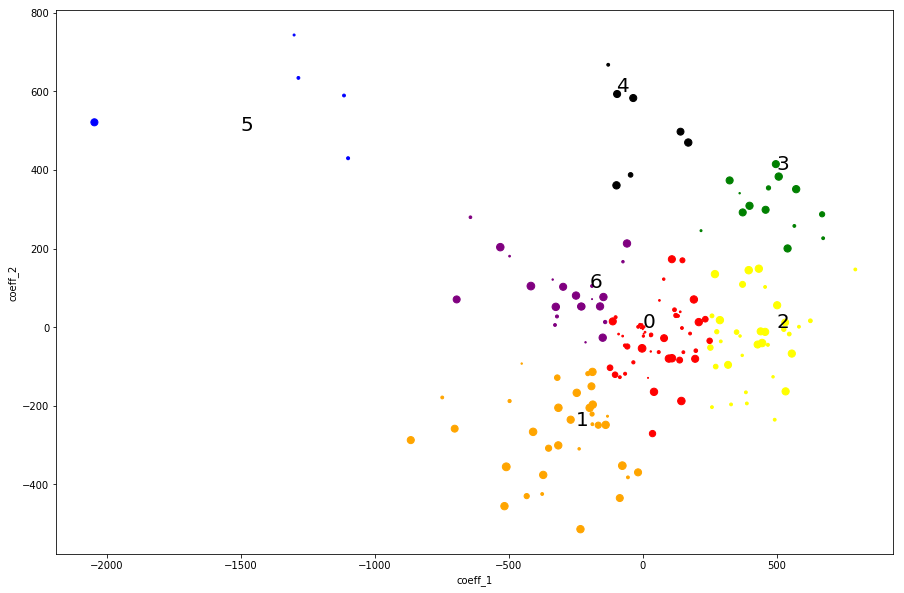

In [50]:


ax1 = coeff_df.plot.scatter(x="coeff_1", y="coeff_2", s=count_list, c=color_map, figsize=(15,10))
for (text_x, text_y, text) in whole_centers:
    plt.text(text_x, text_y, text, color='black', size=20)
#plt.text(x=C[:, 0], y=C[0, :], s=text)

In [54]:
coeff_df.head()

coeff_1     coeff_2
0  501.828895   56.073761
1  440.247446  -10.410478
2  269.624439  135.317346
3  318.556718  -95.619204
4  428.893895  -43.875230

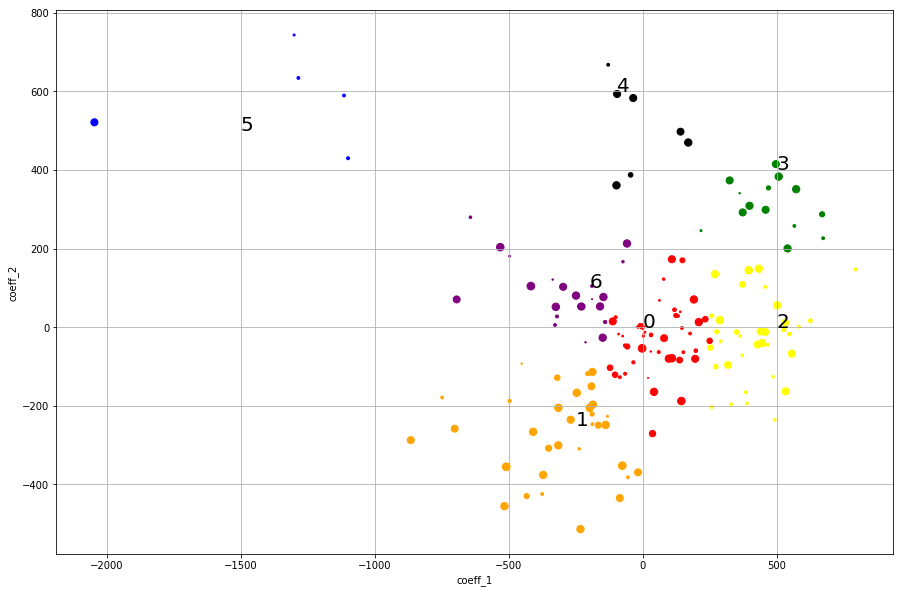

In [154]:
cmap = ['red', 'orange', 'yellow', 'green', 'black', 'blue', 'purple']

###
### YOUR CODE HERE
###

coeff_df = pd.DataFrame(coeffs)
coeff_df.columns = ['coeff_1', 'coeff_2']
count_list = pdf['count'].tolist()
color_map = [cmap[i] for i in group]
text = np.array([0, 1, 2, 3, 4, 5, 6])
whole_centers = np.hstack((C, text.reshape(-1,1)))
ax1 = coeff_df.plot.scatter(x="coeff_1", y="coeff_2", s=count_list, c=color_map, figsize=(15,10))
for (text_x, text_y, text) in whole_centers:
    plt.text(text_x, text_y, text, color='black', size=20)

grid()

## Part 3: Visualizing the stations on the map

In this section, we will use [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/index.html) to visualize the data of `pdf` on an interactive map. 

### Problem 8

The interactive map is also a scatter plot with a real map as the coordinate system. 

- Again the color and the size of the circles represent the number of measurements from the station and the group that the station belongs to. 
- We want to add a blue rectangle to define the boundary of the stations that appeared on the map.
- The coordinate system used in the map is (latitude, longitude).


#### Task:

Follow the instructions below and fill in the blanks (`YOUR CODE HERE`) of the cell to recreate this map step by step. 

1. Step 1:
    1. Find the bounding box of the longitude and latitude in the `pdf` DataFrame
    2. Find the center `(latitude, longitude)` of the bounding box and store it in the `center` variable.
1. Step 2 (provided in the starter code):
    1. Construct the ipyleaflet `Map` object
1. Step 3:
    1. Construct the blue `Rectangle` object as the bounding box and add it to the map. 
        - You only need to use the `bounds` and `fill_opacity` parameters of `Rectangle`.
1. Step 4:
    1. For each row of the `pdf` DataFrame, add a `Circle` object to represent a station on the map. 
    Here are the instructions for the parameters of `Circle`.
        - Use `weight=1`,`opacity=0.7`, and `fill_opacity=0.7`.
        - Use $4800 \times \sqrt{count}$ for `radius`, where $count$ is the `count` of the station. 
        You might want to convert the result to an integer.
        - Use the list `cmap` and the group that the station belongs to determine the color for `fill_color` and `color`. **Again, having correct colors is very important as the questions later rely heavily on this**.
        - You need to figure out what is the value for `location` and you don't have to use other parameters.
1. Step 5 (provided in the starter code):
    1. Show the map


#### Hints:

Useful `ipyleaflet` APIs (note that the parameter documentation of the class that you are looking for might appear in its superclass): 
- [Rectangle](https://ipyleaflet.readthedocs.io/en/latest/_modules/ipyleaflet/leaflet.html#Rectangle)
- [Circle](https://ipyleaflet.readthedocs.io/en/latest/_modules/ipyleaflet/leaflet.html#Circle)
    
Your plot should be the same as the one shown below, except that your plot should have colors and is interactive. 

![Problem 8](figs/prob8.png "Map")

In [58]:
pdf.head()

Station     coeff_1     coeff_2  Longitude  Latitude  count  group
0  IN001020700  501.828895   56.073761     77.633    14.583     52      2
1  IN001050200  440.247446  -10.410478     82.233    16.950     50      2
2  IN001080500  269.624439  135.317346     78.470    17.450     54      2
3  IN001090500  318.556718  -95.619204     79.433    18.767     49      2
4  IN001111200  428.893895  -43.875230     81.150    16.200     50      2

In [65]:
max_lat = pdf['Latitude'].max()
min_lat = pdf['Latitude'].min()

max_long = pdf['Longitude'].max()
min_long = pdf['Longitude'].min()

max_lat
min_lat

lat_center = (max_lat + min_lat)/2
lat_center

long_center = (max_long + min_long)/2
long_center

center = (lat_center, long_center)
center

(21.082999999999995, 82.23349999999999)

In [155]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps, basemap_to_tiles
)

# Step 1
###
### YOUR CODE HERE
###

max_lat = pdf['Latitude'].max()
min_lat = pdf['Latitude'].min()

max_long = pdf['Longitude'].max()
min_long = pdf['Longitude'].min()

lat_center = (max_lat + min_lat)/2

long_center = (max_long + min_long)/2

center = (lat_center, long_center)

# Step 2
zoom = 5
m = Map(basemap=basemaps.OpenStreetMap.HOT, default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

# Step 3
###
### YOUR CODE HERE
###
bounds=[(min_lat, min_long), (max_lat, max_long)]
rectangle = Rectangle(bounds=bounds, fill_opacity=0, color="blue")
m.add_layer(rectangle)

# Step 4
###
### YOUR CODE HERE
###

for index, row in pdf.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    count = row['count']
    radius = int(4800*sqrt(count))
    #color_map = [cmap[i] for i in row['group']
    color = cmap[row['group']]

    
    circle = Circle(location=(lat, lon), radius=radius, fill_color=color, weight=1, opacity=0.7, fill_opacity = 0.7)
    m.add_layer(circle)

# Step 5
m    

Map(basemap={'url': 'http://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>, Tiles courtesy of <a href="http://hot.openstreetmap.org/" target="_blank">Humanitarian OpenStreetMap Team</a>', 'name': 'OpenStreetMap.HOT'}, center=[21.082999999999995, 82.23349999999999], layers=(TileLayer(attribution='&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>, Tiles courtesy of <a href="http://hot.openstreetmap.org/" target="_blank">Humanitarian OpenStreetMap Team</a>', base=True, max_zoom=19, min_zoom=1, name='OpenStreetMap.HOT', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size'], url='http://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png'), Rectangle(bounds=[(8.083, 68.85), (34.08299999999999, 95.617)], color='blue', fill_opacity=0.0, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'no_clip', 'opacity', 'pointer_events', 'smooth_factor', 'stroke', 'weight']), Circle(fill_color='yellow', fill_opacity=0.7, location=[14.583, 77.63300000000001], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=34613, weight=1), Circle(fill_color='yellow', fill_opacity=0.7, location=[16.95, 82.23299999999999], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=33941, weight=1), Circle(fill_color='yellow', fill_opacity=0.7, location=[17.449999999999996, 78.47000000000001], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=35272, weight=1), Circle(fill_color='yellow', fill_opacity=0.7, location=[18.766999999999996, 79.433], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=33600, weight=1), Circle(fill_color='yellow', fill_opacity=0.7, location=[16.199999999999996, 81.15], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=33941, weight=1), Circle(fill_color='red', fill_opacity=0.7, location=[16.533, 80.79999999999998], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=26290, weight=1), Circle(fill_color='yellow', fill_opacity=0.7, location=[15.800000000000002, 78.067], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=32907, weight=1), Circle(fill_color='yellow', fill_opacity=0.7, location=[14.449999999999998, 79.98299999999998], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=34613, weight=1), Circle(fill_color='yellow', fill_opacity=0.7, location=[18.667, 78.1], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight'], radius=14400, weight=1), Circle(fill_color='yellow', fill_opacity=0.7, location=[18.333000000000002, 84.133], opacity=0.7, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 

## Part 4: Yearly temperature profile

Lastly, we want to plot the average TAVG measurements of each group as a function of the days in a year. To do this, we first need to construct a pandas DataFrame `profile` from `df2` that only has stations, decoded temperature values, and the group that the station belongs. Note that each row in `profile` is a measurement, so the names in `Stations` column are not unique.

In [156]:
full_data = df2.rdd.map(lambda x: (x.Station, x.Year, unpackAndScale(x))).collect()
profile = pd.DataFrame({'Station':[f[0] for f in full_data], 'Values':[f[2] for f in full_data]})
profile = profile.merge(pdf[['Station', 'group']], on='Station')
profile.head()

Station                                             Values  group
0  IN017121000  [184.0, 187.0, 181.0, 207.0, 203.0, 187.0, 201...      0
1  IN017121000  [191.0, 195.0, 192.0, 198.0, 209.0, 209.0, 221...      0
2  IN017121000  [179.0, 183.0, 187.0, 197.0, 188.0, 178.0, 190...      0
3  IN017121000  [192.0, 188.0, 180.0, 166.0, 166.0, 165.0, 168...      0
4  IN017121000  [203.0, 207.0, 197.0, 190.0, 206.0, 209.0, 194...      0

Then we use data in `profile` DataFrame to plot the yearly temperature profiles (the average TAVG measurements of each group as the function of the days in a year). Here we hide the codes that we used to generate the profile graph on purpose, but the profile graph is shown below.
- We can see 7 waveforms in the graph, each of which corresponds to the yearly temperature profile of a group.
- Note that the colors used in the scatterplot/map and the profiles do **not** match.

![Problem 7](figs/prob9.png "Profile")

In [157]:
## The hidden code to generate the profile graph. You can ignore this cell.
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### Problem 9

The following problem summarizes this homework. You are asked to relate different characterizations of the same group. To answer this question, you might want to go back to the visualization tools earlier in the notebook. 

In this notebook, we have characterized the clusters (groups) of the stations in 3 aspects: 
1. [A cluster in the scatterplot](#Problem-7).
    - group 0: 'red'
    - group 1: 'orange'
    - group 2: 'yellow'
    - group 3: 'green'
    - group 4: 'black'
    - group 5: 'blue'
    - group 6: 'purple'
1. [A geographical description of a region in India](#Problem-8) (One region is not described on purpose).
    - region A: Southern west coast
    - region B: Southern east coast
    - region C: New Delhi Area
    - region D: The area around Rajkot/Jamnagar
    - region E: Along the Brahmaputra river between Dibrugarh and Guwahati
    - region F: Mountain range in the south-west, between Bengaluru and Belagavi
1. [A yearly temperature profile](#Part-4:-Yearly-temperature-profile).
    - waveform a
    - waveform b
    - waveform c
    - waveform d
    - waveform e
    - waveform f
    - waveform g

#### Task:

Figure out 6 tuples of the form `(group, region, waveform)`, where the group, region, and waveform in each tuple are characterizing the same cluster (group). That is, figure out which `group` and which `waveform` each `region` corresponds to. Put your answers in 2 dictionaries below where the key is the `region` in uppercase letter and the value is your answer (number for `group` and lowercase letter for `waveform`). 

For example, the template provided in the cell below says that `(group 0, region 'A', waveform 'a')` are characterizing the same cluster (group), `(group 1, region 'B', waveform 'b')` are characterizing another cluster (group), and so on.

**You only need to give the answer (2 dictionaries). You don't have to include the codes that you used to get the answer, since we only grade on the correctness of your answer.**

#### Hints:

1. First figure out the relations between the groups in the scatterplot and the geographical descriptions.
    1. Find out the area on the `ipyleaflet` map based on the description.
    1. An area corresponds to a group in the scatterplot if they share the same color.
1. There are several ways that you can do to figure out which group each waveform of the yearly temperature profiles corresponds to.
    1. Plot the yearly temperature profile by yourself for each group using `profile` DataFrame and compare the shapes of waveforms in your plot and in the plot we showed.
    1. Decompose the yearly temperature profile vectors to get the first 2 coefficients. See where the coefficients are in the scatterplot and which group the coefficients are near to.

In [79]:
profile.head()

Station                                             Values  group
0  IN017121000  [184.0, 187.0, 181.0, 207.0, 203.0, 187.0, 201...      0
1  IN017121000  [191.0, 195.0, 192.0, 198.0, 209.0, 209.0, 221...      0
2  IN017121000  [179.0, 183.0, 187.0, 197.0, 188.0, 178.0, 190...      0
3  IN017121000  [192.0, 188.0, 180.0, 166.0, 166.0, 165.0, 168...      0
4  IN017121000  [203.0, 207.0, 197.0, 190.0, 206.0, 209.0, 194...      0

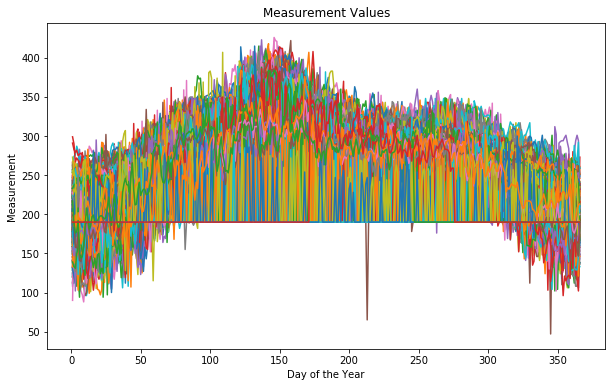

In [109]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Iterate over the rows of the DataFrame
for index, row in group_0.iterrows():
    values = row['Values']
    
    # Plot the values array
    ax.plot(range(1, 367), values)

# Add labels and title to the plot
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Measurement')
ax.set_title('Measurement Values')

# Show the plot
plt.show()


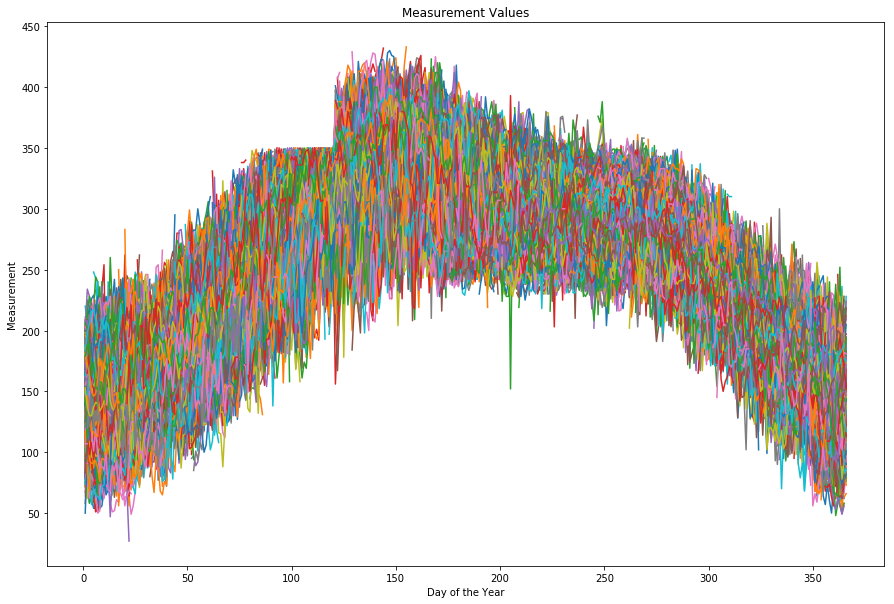

In [110]:
group_1 = profile[profile['group'] == 1]
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15,10))

# Iterate over the rows of the DataFrame
for index, row in group_1.iterrows():
    values = row['Values']
    
    # Plot the values array
    ax.plot(range(1, 367), values)

# Add labels and title to the plot
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Measurement')
ax.set_title('Measurement Values')

# Show the plot
plt.show()

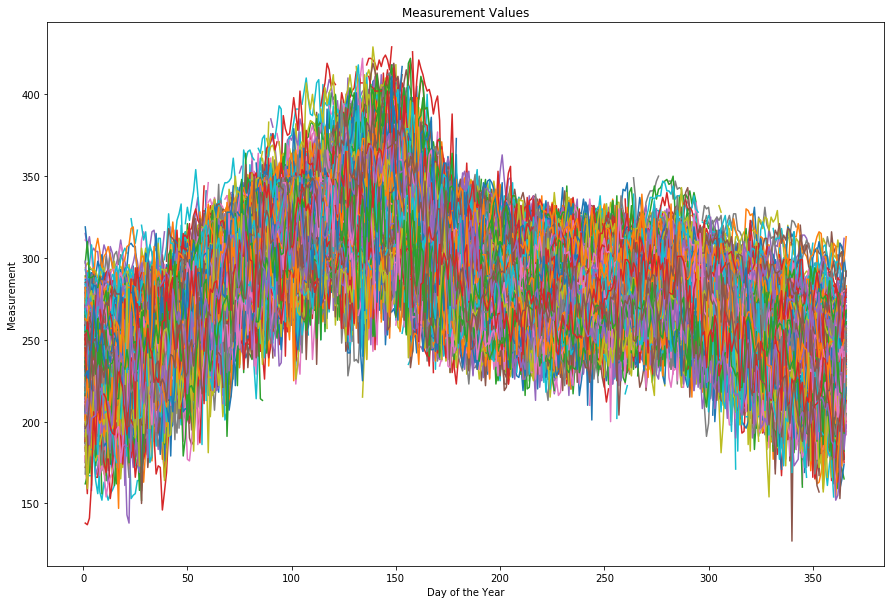

In [111]:
group_2 = profile[profile['group'] == 2]
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15,10))

# Iterate over the rows of the DataFrame
for index, row in group_2.iterrows():
    values = row['Values']
    
    # Plot the values array
    ax.plot(range(1, 367), values)

# Add labels and title to the plot
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Measurement')
ax.set_title('Measurement Values')

# Show the plot
plt.show()

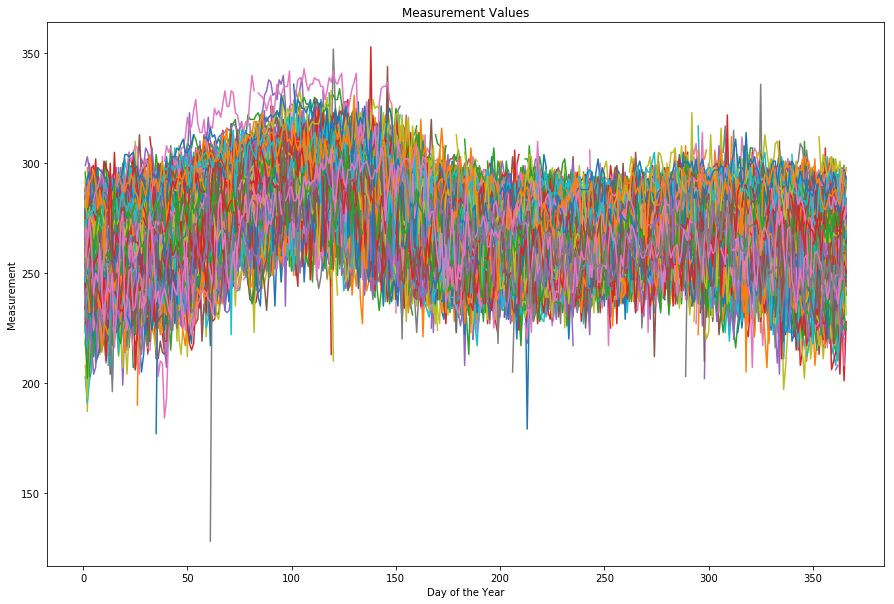

In [112]:
group_3 = profile[profile['group'] == 3]
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15,10))

# Iterate over the rows of the DataFrame
for index, row in group_3.iterrows():
    values = row['Values']
    
    # Plot the values array
    ax.plot(range(1, 367), values)

# Add labels and title to the plot
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Measurement')
ax.set_title('Measurement Values')

# Show the plot
plt.show()

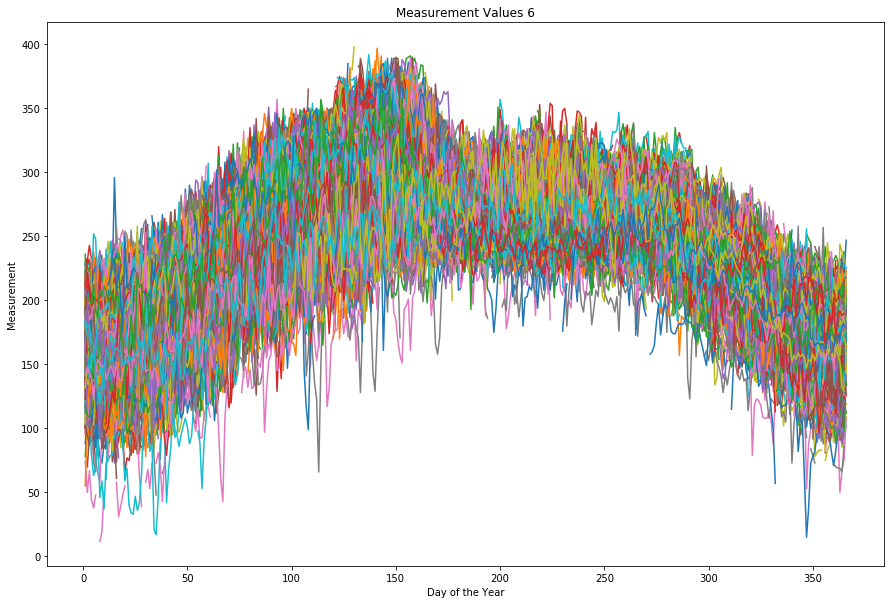

In [114]:
group_6 = profile[profile['group'] == 6]
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15,10))

# Iterate over the rows of the DataFrame
for index, row in group_6.iterrows():
    values = row['Values']
    
    # Plot the values array
    ax.plot(range(1, 367), values)

# Add labels and title to the plot
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Measurement')
ax.set_title('Measurement Values 6')

# Show the plot
plt.show()

In [96]:
group_0 = profile[profile['group'] == 0]
group_0

Station                                             Values  group
0     IN017121000  [184.0, 187.0, 181.0, 207.0, 203.0, 187.0, 201...      0
1     IN017121000  [191.0, 195.0, 192.0, 198.0, 209.0, 209.0, 221...      0
2     IN017121000  [179.0, 183.0, 187.0, 197.0, 188.0, 178.0, 190...      0
3     IN017121000  [192.0, 188.0, 180.0, 166.0, 166.0, 165.0, 168...      0
4     IN017121000  [203.0, 207.0, 197.0, 190.0, 206.0, 209.0, 194...      0
5     IN017121000  [nan, nan, 140.0, 200.0, 178.0, 204.0, 194.0, ...      0
6     IN017121000  [185.0, nan, nan, nan, nan, 210.0, nan, nan, 2...      0
7     IN017121000  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
8     IN017121000  [188.0, 193.0, 184.0, 180.0, 177.0, 174.0, 183...      0
9     IN017121000  [201.0, 207.0, 209.0, 222.0, 223.0, 212.0, 223...      0
10    IN017121000  [197.0, 186.0, 187.0, 193.0, 197.0, 189.0, 193...      0
11    IN017121000  [214.0, 179.0, 188.0, 208.0, 199.0, 186.0, 166...      0
12    IN017121000  [216.0, nan, nan, nan, nan, nan, nan, nan, nan...      0
13    IN017121000  [198.0, nan, 201.0, 172.0, 205.0, 219.0, 199.0...      0
14    IN017121000  [nan, nan, nan, 186.0, nan, 184.0, 191.0, 227....      0
15    IN017121000  [217.0, 206.0, 204.0, 212.0, 191.0, 177.0, 180...      0
16    IN017121000  [207.0, 197.0, 196.0, 187.0, 188.0, 189.0, 195...      0
17    IN017121000  [205.0, 207.0, 198.0, 188.0, 195.0, 206.0, 202...      0
18    IN017121000  [199.0, 172.0, 161.0, 154.0, 153.0, 154.0, 159...      0
19    IN017121000  [215.0, 231.0, 213.0, 194.0, 198.0, 203.0, 201...      0
20    IN017121000  [210.0, 194.0, 184.0, 199.0, 207.0, 206.0, 199...      0
21    IN017121000  [nan, 192.0, 212.0, 220.0, 193.0, nan, 217.0, ...      0
22    IN017121000  [187.0, 211.0, 200.0, 178.0, 195.0, 230.0, nan...      0
23    IN017121000  [174.0, 171.0, 193.0, 199.0, 181.0, nan, 184.0...      0
24    IN017121000  [nan, nan, 174.0, nan, nan, 183.0, 207.0, nan,...      0
25    IN017121000  [191.0, 179.0, 186.0, 212.0, 212.0, 192.0, 198...      0
26    IN017121000  [90.0, 181.0, nan, 170.0, 176.0, 165.0, 155.0,...      0
27    IN017121000  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
28    IN017121000  [nan, 198.0, 198.0, 177.0, 163.0, 187.0, 211.0...      0
29    IN017121000  [218.0, 214.0, 221.0, 222.0, 241.0, 242.0, 244...      0
...           ...                                                ...    ...
4751  IN004170200  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4752  IN023480200  [nan, nan, nan, 172.0, nan, nan, nan, nan, nan...      0
4753  IN011031100  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4754  IN019190400  [nan, nan, nan, nan, nan, nan, nan, nan, 172.0...      0
4755  IN019190400  [nan, nan, nan, nan, nan, nan, 206.0, 160.0, n...      0
4756  IN019190400  [171.0, 192.0, 167.0, 186.0, 183.0, 172.0, 186...      0
4757  IN019190400  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4758  IN019190400  [153.0, nan, nan, nan, nan, nan, nan, nan, nan...      0
4759  IN019190400  [139.0, 133.0, 131.0, 149.0, 160.0, 167.0, 162...      0
4760  IN019190400  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4761  IN019190400  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4762  IN020021800  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4771  IN004120400  [nan, nan, nan, nan, nan, nan, 230.0, nan, nan...      0
4774  IN017042600  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4775  IN023340700  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4776  IN005091300  [178.0, 155.0, 198.0, 190.0, 195.0, 193.0, 184...      0
4777  IN005091300  [207.0, 162.0, 172.0, 182.0, 177.0, 188.0, nan...      0
4778  IN005091300  [202.0, 185.0, nan, 178.0, 202.0, 190.0, 162.0...      0
4779  IN011160200  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4780  IN011370100  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      0
4783  IN024140400  [158.0, 147.0, 162.0, 167.0, 172.0, 176

In [100]:
group_0['Values'] = group_0['Values'].apply(lambda x: [190 if np.isnan(value) else value for value in x])



In [104]:
#mean_0 = np.mean(group_0['Values'])
mean_0 = group_0['Values'].apply(lambda x: np.nanmean(x))


In [106]:
grouped_0 = group_0.groupby('group')['Values'].apply(lambda x: np.nanmean(np.vstack([np.nan_to_num(arr, nan=np.nan) for arr in x]), axis=0))

ValueError: x and y must have same first dimension, but have shapes (366,) and (1,)

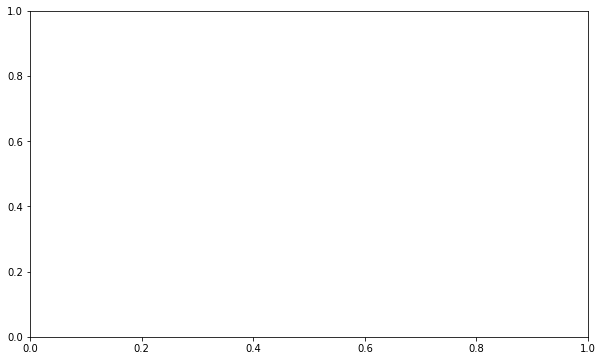

In [107]:
import numpy as np
import matplotlib.pyplot as plt

grouped_data = profile.groupby('group')['Values'].apply(lambda x: np.nanmean(np.vstack([np.nan_to_num(arr, nan=np.nan) for arr in x]), axis=0))
days = np.arange(1, 367)

plt.figure(figsize=(10, 6))
#for i, group_data in enumerate(grouped_data):
    # Check if any "inf" values exist in the group_data
#    if np.isinf(group_data).any():
#        group_data = np.where(np.isinf(group_data), np.nan, group_data)  # Replace "inf" with NaN

plt.plot(days, grouped_0)

plt.xlabel('Day')
plt.ylabel('Average Temperature')
plt.title('Yearly Temperature Profiles')
plt.legend()
plt.show()

In [105]:
mean_0

0              inf
1       205.019126
2       272.546448
3       267.707650
4       264.256831
5       238.855191
6       206.262295
7       223.519126
8       263.196721
9       267.213115
10      263.926230
11      264.098361
12      235.005464
13      229.715847
14      232.213115
15      267.297814
16      266.863388
17      264.382514
18      262.265027
19      262.065574
20      261.972678
21      248.942623
22      244.379781
23      253.210383
24      219.642077
25      262.218579
26      242.677596
27      201.685792
28      200.486339
29      274.650273
           ...    
4751    190.355191
4752    189.950820
4753    190.090164
4754    190.407104
4755    199.027322
4756    260.841530
4757    194.234973
4758    192.374317
4759    250.428962
4760    246.789617
4761    222.846995
4762    190.133880
4771    190.163934
4774    190.240437
4775    189.830601
4776    218.486339
4777    205.983607
4778    227.234973
4779    190.095628
4780    190.218579
4783    215.590164
4784    254.

In [94]:
group_0 = group_0['Values'].fillna(190, inplace=True)
group_0

In [95]:
print(group_0)

None


In [87]:
# Calculate the mean of the 'Values' column
mean_value = group_0['Values'].mean()

# Replace NaN values with the mean
#group_0['Values'].fillna(mean_value, inplace=True)
mean_value

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [85]:
# Compute the average of the 'Values' column, ignoring NaN values
average_values = np.nanmean(group_0['Values'].tolist(), axis=0)

# Display the averaged values array
print(average_values)

[  inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf   inf   inf   inf   inf   

In [67]:
df['Values'] = profile['Values'].apply(lambda x: Vectors.dense(x))

NameError: name 'Vectors' is not defined

In [ ]:


# Group the data by 'group' and collect the Vectors as a list
grouped_df = df.groupBy('group').agg(collect_list('Values').alias('Values_list'))

# Convert the collected list of Vectors to a DataFrame
grouped_vectors_df = grouped_df.selectExpr('group', 'explode(Values_list) as Values')

# Create a PCA instance and fit the data
pca = PCA(k=2, inputCol='Values', outputCol='coefficients')
model = pca.fit(grouped_vectors_df)

# Transform the data to obtain the coefficients
transformed_df = model.transform(grouped_vectors_df)

# Collect the coefficients as a Pandas DataFrame for plotting
coefficients_df = transformed_df.select('group', 'coefficients').toPandas()

# Create a scatterplot of the coefficients
plt.scatter(coefficients_df['coefficients'].apply(lambda x: x[0]),
            coefficients_df['coefficients'].apply(lambda x: x[1]))
plt.xlabel('Coefficient 1')
plt.ylabel('Coefficient 2')

# Annotate the scatterplot with group labels
for i, row in coefficients_df.iterrows():
    group = row['group']
    plt.annotate(f'Group {group}', (row['coefficients'][0], row['coefficients'][1]))

# Show the scatterplot
plt.show()

In [64]:
Query="""
select Values
from profile
WHERE group = 0
"""
df = sqlContext.sql(Query)

df2 = decompose_dataframe(sqlContext, df, EigVec, Mean).cache()
df2.toPandas().head()

AnalysisException: 'Table or view not found: profile; line 3 pos 5'

In [50]:
average_temperatures = df.groupBy('group').pivot('dayofyear').agg(F.mean('Values')).orderBy('group')

AnalysisException: "cannot resolve '`dayofyear`' given input columns: [weather.elevation, weather.Station, weather.longitude, weather.dist2coast, weather.latitude, weather.name, weather.Year, weather.state, weather.country, weather.Values, weather.Measurement];;\n'Project ['dayofyear]\n+- AnalysisBarrier\n      +- Project [Station#0, Measurement#1, Year#2, Values#3, latitude#4, longitude#5, elevation#6, dist2coast#7, name#8, state#9, country#10]\n         +- Filter ((country#10 = India) && (measurement#1 = TAVG))\n            +- SubqueryAlias weather\n               +- Relation[Station#0,Measurement#1,Year#2,Values#3,latitude#4,longitude#5,elevation#6,dist2coast#7,name#8,state#9,country#10] parquet\n"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

# Calculate the average temperature for each day in a year
average_temperatures = df.groupby('group')['Values'].apply(lambda x: np.nanmean(x.values, axis=0))

# Create a DataFrame from the average temperatures
average_df = pd.DataFrame(average_temperatures.tolist(), columns=range(1, 367))

# Plotting the yearly temperature profiles
x = range(1, 367)
y = average_df.values.T
group_labels = range(7)

plt.figure(figsize=(10, 6))
for i in range(7):
    plt.plot(x, y[:, i], label=f'Group {group_labels[i]}')

plt.xlabel('Day of the Year')
plt.ylabel('Average Temperature')
plt.title('Yearly Temperature Profiles')
plt.legend()
plt.show()


In [58]:
grouped = profile.groupby(['group'])

In [59]:
grouped.head()

Station                                             Values  group
0    IN017121000  [184.0, 187.0, 181.0, 207.0, 203.0, 187.0, 201...      0
1    IN017121000  [191.0, 195.0, 192.0, 198.0, 209.0, 209.0, 221...      0
2    IN017121000  [179.0, 183.0, 187.0, 197.0, 188.0, 178.0, 190...      0
3    IN017121000  [192.0, 188.0, 180.0, 166.0, 166.0, 165.0, 168...      0
4    IN017121000  [203.0, 207.0, 197.0, 190.0, 206.0, 209.0, 194...      0
104  IN008040500  [97.0, 115.0, 124.0, 120.0, 104.0, 103.0, 103....      1
105  IN008040500  [123.0, 122.0, 124.0, 110.0, 116.0, 106.0, 119...      1
106  IN008040500  [122.0, 124.0, 129.0, 128.0, 122.0, 128.0, 129...      1
107  IN008040500  [99.0, 129.0, 141.0, 160.0, 141.0, 150.0, 142....      1
108  IN008040500  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      1
112  IN023420800  [39.0, 17.0, 32.0, 17.0, 29.0, 38.0, nan, 9.0,...      5
113  IN023420800  [118.0, 106.0, 49.0, 93.0, 100.0, 49.0, 106.0,...      5
114  IN023420800  [87.0, 103.0, 105.0, 102.0, 59.0, 51.0, 76.0, ...      5
115  IN023420800  [68.0, 57.0, 81.0, 100.0, 73.0, 74.0, 81.0, na...      5
116  IN023420800  [57.0, 67.0, 88.0, 92.0, 89.0, 97.0, nan, 18.0...      5
290  IN001020700  [253.0, 249.0, 240.0, 244.0, 226.0, 216.0, 230...      2
291  IN001020700  [224.0, 228.0, 226.0, 231.0, 228.0, 230.0, 231...      2
292  IN001020700  [231.0, 224.0, 242.0, 243.0, 241.0, 242.0, 232...      2
293  IN001020700  [233.0, 236.0, 234.0, 237.0, 242.0, 252.0, 245...      2
294  IN001020700  [246.0, 243.0, 235.0, 226.0, 219.0, 236.0, 251...      2
342  IN009070100  [227.0, 233.0, 227.0, 224.0, 220.0, 222.0, 218...      4
343  IN009070100  [247.0, 247.0, 244.0, 244.0, 240.0, 241.0, 246...      4
344  IN009070100  [223.0, 242.0, 245.0, 243.0, 234.0, 229.0, 230...      4
345  IN009070100  [223.0, 223.0, 221.0, 211.0, 210.0, 223.0, 231...      4
346  IN009070100  [263.0, 256.0, 258.0, 259.0, 256.0, 243.0, 242...      4
695  IN009130300  [264.0, 254.0, 256.0, 263.0, 257.0, 254.0, 262...      3
696  IN009130300  [262.0, 261.0, 260.0, 260.0, 261.0, 267.0, 268...      3
697  IN009130300  [262.0, 259.0, 272.0, 269.0, 266.0, 263.0, 259...      3
698  IN009130300  [282.0, 280.0, 272.0, 267.0, 261.0, 258.0, 261...      3
699  IN009130300  [247.0, 246.0, 247.0, 266.0, 267.0, 265.0, 264...      3
861  IN011020300  [197.0, 194.0, 205.0, 202.0, 219.0, 233.0, 233...      6
862  IN011020300  [215.0, 219.0, 192.0, 189.0, 192.0, 191.0, 204...      6
863  IN011020300  [204.0, 207.0, 203.0, 203.0, 211.0, 214.0, 224...      6
864  IN011020300  [202.0, 198.0, 190.0, 179.0, 168.0, 152.0, 143...      6
865  IN011020300  [206.0, 208.0, 200.0, 192.0, 186.0, 178.0, 181...      6

In [61]:
#
# Create a new DataFrame with rows where 'group' is 0
group_zero_df = grouped[grouped['group'] == 1].copy()

# Display the new DataFrame
print(group_zero_df)


KeyError: 'Column not found: False'

In [54]:
groupzero = grouped.iloc[:5, 1:3].copy()

AttributeError: Cannot access callable attribute 'iloc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [56]:
grouped.iloc[:5, 1:3]

AttributeError: Cannot access callable attribute 'iloc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [55]:
grouped.head()

Station                                             Values  group
0    IN017121000  [184.0, 187.0, 181.0, 207.0, 203.0, 187.0, 201...      0
1    IN017121000  [191.0, 195.0, 192.0, 198.0, 209.0, 209.0, 221...      0
2    IN017121000  [179.0, 183.0, 187.0, 197.0, 188.0, 178.0, 190...      0
3    IN017121000  [192.0, 188.0, 180.0, 166.0, 166.0, 165.0, 168...      0
4    IN017121000  [203.0, 207.0, 197.0, 190.0, 206.0, 209.0, 194...      0
104  IN008040500  [97.0, 115.0, 124.0, 120.0, 104.0, 103.0, 103....      1
105  IN008040500  [123.0, 122.0, 124.0, 110.0, 116.0, 106.0, 119...      1
106  IN008040500  [122.0, 124.0, 129.0, 128.0, 122.0, 128.0, 129...      1
107  IN008040500  [99.0, 129.0, 141.0, 160.0, 141.0, 150.0, 142....      1
108  IN008040500  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      1
112  IN023420800  [39.0, 17.0, 32.0, 17.0, 29.0, 38.0, nan, 9.0,...      5
113  IN023420800  [118.0, 106.0, 49.0, 93.0, 100.0, 49.0, 106.0,...      5
114  IN023420800  [87.0, 103.0, 105.0, 102.0, 59.0, 51.0, 76.0, ...      5
115  IN023420800  [68.0, 57.0, 81.0, 100.0, 73.0, 74.0, 81.0, na...      5
116  IN023420800  [57.0, 67.0, 88.0, 92.0, 89.0, 97.0, nan, 18.0...      5
290  IN001020700  [253.0, 249.0, 240.0, 244.0, 226.0, 216.0, 230...      2
291  IN001020700  [224.0, 228.0, 226.0, 231.0, 228.0, 230.0, 231...      2
292  IN001020700  [231.0, 224.0, 242.0, 243.0, 241.0, 242.0, 232...      2
293  IN001020700  [233.0, 236.0, 234.0, 237.0, 242.0, 252.0, 245...      2
294  IN001020700  [246.0, 243.0, 235.0, 226.0, 219.0, 236.0, 251...      2
342  IN009070100  [227.0, 233.0, 227.0, 224.0, 220.0, 222.0, 218...      4
343  IN009070100  [247.0, 247.0, 244.0, 244.0, 240.0, 241.0, 246...      4
344  IN009070100  [223.0, 242.0, 245.0, 243.0, 234.0, 229.0, 230...      4
345  IN009070100  [223.0, 223.0, 221.0, 211.0, 210.0, 223.0, 231...      4
346  IN009070100  [263.0, 256.0, 258.0, 259.0, 256.0, 243.0, 242...      4
695  IN009130300  [264.0, 254.0, 256.0, 263.0, 257.0, 254.0, 262...      3
696  IN009130300  [262.0, 261.0, 260.0, 260.0, 261.0, 267.0, 268...      3
697  IN009130300  [262.0, 259.0, 272.0, 269.0, 266.0, 263.0, 259...      3
698  IN009130300  [282.0, 280.0, 272.0, 267.0, 261.0, 258.0, 261...      3
699  IN009130300  [247.0, 246.0, 247.0, 266.0, 267.0, 265.0, 264...      3
861  IN011020300  [197.0, 194.0, 205.0, 202.0, 219.0, 233.0, 233...      6
862  IN011020300  [215.0, 219.0, 192.0, 189.0, 192.0, 191.0, 204...      6
863  IN011020300  [204.0, 207.0, 203.0, 203.0, 211.0, 214.0, 224...      6
864  IN011020300  [202.0, 198.0, 190.0, 179.0, 168.0, 152.0, 143...      6
865  IN011020300  [206.0, 208.0, 200.0, 192.0, 186.0, 178.0, 181...      6

In [73]:
grouped2 = profile.groupby('group').apply(lambda x: x['Values'].tolist()).reset_index(name='Values_list')

In [75]:
grouped2.head()

group                                        Values_list
0      0  [[184.0, 187.0, 181.0, 207.0, 203.0, 187.0, 20...
1      1  [[97.0, 115.0, 124.0, 120.0, 104.0, 103.0, 103...
2      2  [[253.0, 249.0, 240.0, 244.0, 226.0, 216.0, 23...
3      3  [[264.0, 254.0, 256.0, 263.0, 257.0, 254.0, 26...
4      4  [[227.0, 233.0, 227.0, 224.0, 220.0, 222.0, 21...

In [78]:
import numpy as np
import matplotlib.pyplot as plt

#grouped_data = profile.groupby('group')['Values'].apply(lambda x: np.nanmean(np.vstack([np.nan_to_num(arr, nan=np.nan) for arr in x]), axis=0))
days = np.arange(1, 367)

plt.figure(figsize=(10, 6))
for i, grouped2 in enumerate(grouped2):
    # Check if any "inf" values exist in the group_data
    if np.isinf(grouped2).any():
        group_data = np.where(np.isinf(group_data), np.nan, group_data)  # Replace "inf" with NaN

    plt.plot(days, group_data, label=f'Group {i+1}')

plt.xlabel('Day')
plt.ylabel('Average Temperature')
plt.title('Yearly Temperature Profiles')
plt.legend()
plt.show()

TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 720x432 with 0 Axes>

In [77]:
for i, row in grouped.iterrows():
    group = row['group']
    values = np.array(row['Values_list'], dtype=np.float32)  # Convert values to float32
    
    # Perform decomposition on the values to get the first 2 coefficients
    coefficients = np.polyfit(range(len(values)), values, 1)[:2]
    
    # Print or use the coefficients as needed
    print(f"Group {group} coefficients: {coefficients}")

AttributeError: Cannot access callable attribute 'iterrows' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [74]:
value1 = grouped2.loc[1, "Values"]

KeyError: 'the label [Values] is not in the [index]'

In [139]:
profile['Values'] = profile['Values'].apply(lambda arr: np.nan_to_num(arr, nan=0))

In [72]:
value1 = grouped.loc[1, "Values"]
value1

AttributeError: Cannot access callable attribute 'loc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [142]:
grouped_data

group
0    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
1    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
2    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
3    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
4    [191.8, 191.6, 190.5, 197.5, 196.2, 194.6, 197...
5    [37.22, 34.94, 34.78, 36.6, 33.03, 32.8, 29.06...
6    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
Name: Values, dtype: object

In [143]:
grouped_data[1]

array([  inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,

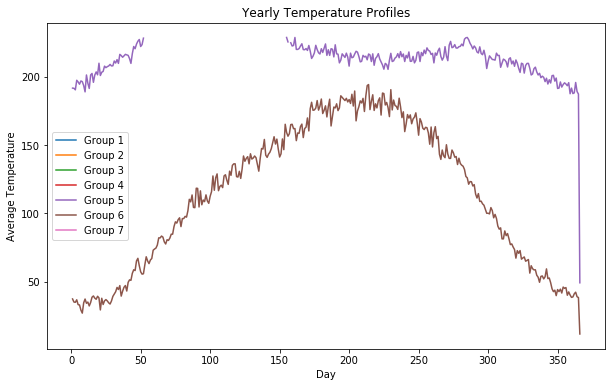

In [141]:
import numpy as np
import matplotlib.pyplot as plt

grouped_data = profile.groupby('group')['Values'].apply(lambda x: np.nanmean(np.vstack([np.nan_to_num(arr, nan=np.nan) for arr in x]), axis=0))
days = np.arange(1, 367)

plt.figure(figsize=(10, 6))
for i, group_data in enumerate(grouped_data):
    # Check if any "inf" values exist in the group_data
    if np.isinf(group_data).any():
        group_data = np.where(np.isinf(group_data), np.nan, group_data)  # Replace "inf" with NaN

    plt.plot(days, group_data, label=f'Group {i+1}')

plt.xlabel('Day')
plt.ylabel('Average Temperature')
plt.title('Yearly Temperature Profiles')
plt.legend()
plt.show()


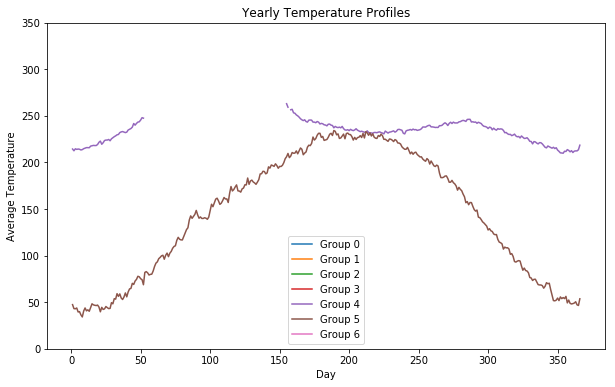

In [127]:
grouped_data = profile.groupby('group')['Values'].apply(lambda x: np.nanmean(np.vstack([np.nan_to_num(arr, nan=np.nan) for arr in x]), axis=0))
days = np.arange(1, 367)

plt.figure(figsize=(10, 6))
for i, group_data in enumerate(grouped_data):
    plt.plot(days, group_data, label=f'Group {i}')

plt.xlabel('Day')
plt.ylabel('Average Temperature')
plt.title('Yearly Temperature Profiles')
plt.legend()
plt.ylim(0, 350)
plt.show()

In [130]:
grouped_data

group
0    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
1    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
2    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
3    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
4    [214.4, 212.5, 214.6, 214.0, 214.4, 214.1, 213...
5    [47.4, 43.12, 42.94, 43.8, 39.53, 39.88, 36.44...
6    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
Name: Values, dtype: object

In [124]:
Query="""
SELECT Values
FROM profile
WHERE group='0'
"""
print(Query)
pandas_df=sqlContext.sql(Query).toPandas()
#pandas_df=pandas_df.set_index('Measurement')
#print('pandas_df.shape=',pandas_df.shape)
#print('pandas_df.columns=',pandas_df.columns)


SELECT Values
FROM profile
WHERE group='0'



AnalysisException: 'Table or view not found: profile; line 3 pos 5'

In [121]:
profile['Values'].dtype

dtype('O')

In [119]:
# Assuming 'profile' is your DataFrame containing the data
values = profile['Values'].apply(lambda x: np.nan_to_num(np.array(x), nan=-999))
groups = profile['group']


In [120]:
# Group the values by the 'group' column and calculate the mean for each group
grouped_values = pd.Series(values.tolist(), index=groups).groupby(groups).mean()


DataError: No numeric types to aggregate

In [115]:
from lib.YearPlotter import YearPlotter
import matplotlib.pyplot as plt

k = 5  # Number of rows to consider for average calculation
_title = 'TOBS for %s / %d' % (station, year)
fig, ax = plt.subplots(figsize=_figsize)

# Step 1: Calculate average temperature
average_temperature = profile.head(k)['Values'].mean(axis=0)

# Step 2: Initialize YearPlotter
YP = YearPlotter()

# Step 3: Plot average temperatures
YP.plot(average_temperature[:366].T, fig, ax, title=_title, labels=_labels)
plt.ylabel('Temperature in Centigrade')

plt.show()


NameError: name 'station' is not defined

In [113]:
target_group = 0

# Boolean indexing to filter rows based on the target group
isolated_rows = profile[profile['group'] == target_group]

isolated_rows.head()

Station                                             Values  group
0  IN017121000  [184.0, 187.0, 181.0, 207.0, 203.0, 187.0, 201...      0
1  IN017121000  [191.0, 195.0, 192.0, 198.0, 209.0, 209.0, 221...      0
2  IN017121000  [179.0, 183.0, 187.0, 197.0, 188.0, 178.0, 190...      0
3  IN017121000  [192.0, 188.0, 180.0, 166.0, 166.0, 165.0, 168...      0
4  IN017121000  [203.0, 207.0, 197.0, 190.0, 206.0, 209.0, 194...      0

In [114]:
average_values0 = np.nanmean(isolated_rows['Values'].values, axis=0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [108]:
value1 = profile.loc[1, "Values"]
value2 = profile.loc[2, "Values"]
average = np.nanmean([value1, value2], axis=0)
average

array([185. , 189. , 189.5, 197.5, 198.5, 193.5, 205.5, 208.5, 207.5,
       193.5, 183. , 195. , 198.5, 197.5, 191. , 192. , 196.5, 195.5,
       196. , 193. , 214. , 223. , 208.5, 220. , 215.5, 186.5, 182.5,
       183.5, 185. , 192.5, 203. , 210.5, 220.5, 220.5, 213.5, 219. ,
       229. , 229.5, 227.5, 216.5, 206. , 205. , 216.5, 225. , 228.5,
       244.5, 221. , 218.5, 227. , 246. , 246. , 251. , 261.5, 261. ,
       265. , 253. , 260. , 262.5, 251.5, 256.5, 263.5, 252. , 265.5,
       273.5, 272. , 269. , 259. , 272. , 274.5, 289. , 286.5, 296. ,
       296. , 274.5, 290. , 282. , 271.5, 284.5, 299.5, 299.5, 295. ,
       310. , 291. , 312.5, 313. , 320.5, 313.5, 318.5, 317.5, 335. ,
       330. , 338.5, 336.5, 341. , 349. , 339. , 322. , 295. , 318. ,
       337. , 336. , 340. , 349. ,   nan,   nan, 350. , 322. , 328. ,
       289. , 314. , 260. , 288. , 332. , 339. , 349. ,   nan,   nan,
         nan,   nan,   nan, 347. , 321. , 288. , 343. , 314. , 357. ,
       368. , 373. ,

In [133]:
value5 = profile.loc[4, "Values"]
value5

array([203., 207., 197., 190., 206., 209., 194., 188., 199., 210., 217.,
       208., 190., 197., 202., 206., 212., 212., 218., 215., 213., 202.,
       211., 218., 218., 205., 199., 196., 197., 198., 198., 199., 200.,
       206., 213., 225., 233., 239., 242., 243., 241., 230., 218., 236.,
       246., 219., 188., 182., 183., 193., 207., 226., 245., 233., 234.,
       248., 247., 231., 202., 223., 231., 233., 198., 213., 229., 238.,
       242., 232., 216., 236., 258., 252., 260., 276., 275., 275., 284.,
       276., 283., 271., 285., 282., 288., 289., 304., 316., 318., 320.,
       323., 317., 306., 303., 314., 306., 307., 313., 326., 322., 317.,
       315., 312., 309., 312., 313., 315., 322., 284., 299., 319., 308.,
       327., 330., 332., 334., 336., 343., 347., 339., 344., 343., 329.,
       327., 328., 319., 311., 311., 332., 319., 306., 281., 327., 347.,
       356., 337., 335., 343., 356., 354., 356., 358., 361., 361., 359.,
       347., 311., 270., 255., 302., 327., 349., 33

In [111]:
def calculate_average(arr):
    arr = np.array(arr)  # Convert to NumPy array
    return np.nanmean(arr, axis=0) if len(arr) > 0 else np.nan

# Apply the custom function to calculate the average
grouped_data = profile.groupby('group')['Values'].apply(calculate_average)

print(grouped_data)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [97]:
new_dataframe = profile.loc[:, ["Values", "group"]]


In [100]:
grouped_data = new_dataframe.groupby('group')

In [102]:
grouped_data.head()

Values  group
0    [184.0, 187.0, 181.0, 207.0, 203.0, 187.0, 201...      0
1    [191.0, 195.0, 192.0, 198.0, 209.0, 209.0, 221...      0
2    [179.0, 183.0, 187.0, 197.0, 188.0, 178.0, 190...      0
3    [192.0, 188.0, 180.0, 166.0, 166.0, 165.0, 168...      0
4    [203.0, 207.0, 197.0, 190.0, 206.0, 209.0, 194...      0
104  [97.0, 115.0, 124.0, 120.0, 104.0, 103.0, 103....      1
105  [123.0, 122.0, 124.0, 110.0, 116.0, 106.0, 119...      1
106  [122.0, 124.0, 129.0, 128.0, 122.0, 128.0, 129...      1
107  [99.0, 129.0, 141.0, 160.0, 141.0, 150.0, 142....      1
108  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      1
112  [39.0, 17.0, 32.0, 17.0, 29.0, 38.0, nan, 9.0,...      5
113  [118.0, 106.0, 49.0, 93.0, 100.0, 49.0, 106.0,...      5
114  [87.0, 103.0, 105.0, 102.0, 59.0, 51.0, 76.0, ...      5
115  [68.0, 57.0, 81.0, 100.0, 73.0, 74.0, 81.0, na...      5
116  [57.0, 67.0, 88.0, 92.0, 89.0, 97.0, nan, 18.0...      5
290  [253.0, 249.0, 240.0, 244.0, 226.0, 216.0, 230...      2
291  [224.0, 228.0, 226.0, 231.0, 228.0, 230.0, 231...      2
292  [231.0, 224.0, 242.0, 243.0, 241.0, 242.0, 232...      2
293  [233.0, 236.0, 234.0, 237.0, 242.0, 252.0, 245...      2
294  [246.0, 243.0, 235.0, 226.0, 219.0, 236.0, 251...      2
342  [227.0, 233.0, 227.0, 224.0, 220.0, 222.0, 218...      4
343  [247.0, 247.0, 244.0, 244.0, 240.0, 241.0, 246...      4
344  [223.0, 242.0, 245.0, 243.0, 234.0, 229.0, 230...      4
345  [223.0, 223.0, 221.0, 211.0, 210.0, 223.0, 231...      4
346  [263.0, 256.0, 258.0, 259.0, 256.0, 243.0, 242...      4
695  [264.0, 254.0, 256.0, 263.0, 257.0, 254.0, 262...      3
696  [262.0, 261.0, 260.0, 260.0, 261.0, 267.0, 268...      3
697  [262.0, 259.0, 272.0, 269.0, 266.0, 263.0, 259...      3
698  [282.0, 280.0, 272.0, 267.0, 261.0, 258.0, 261...      3
699  [247.0, 246.0, 247.0, 266.0, 267.0, 265.0, 264...      3
861  [197.0, 194.0, 205.0, 202.0, 219.0, 233.0, 233...      6
862  [215.0, 219.0, 192.0, 189.0, 192.0, 191.0, 204...      6
863  [204.0, 207.0, 203.0, 203.0, 211.0, 214.0, 224...      6
864  [202.0, 198.0, 190.0, 179.0, 168.0, 152.0, 143...      6
865  [206.0, 208.0, 200.0, 192.0, 186.0, 178.0, 181...      6

In [93]:
grouped_data = profile.groupby('group')

In [89]:
profile['Values'] = profile['Values'].apply(np.array)

In [91]:
def custom_mean(arr):
    arr = np.array(arr)
    return np.mean(arr[~np.isinf(arr)])

# Convert the list values to numpy arrays
profile['Values'] = profile['Values'].apply(np.array)

# Group by "group" column and calculate the mean for each day of the year
grouped_data = profile.groupby('group')['Values'].apply(lambda x: np.apply_along_axis(custom_mean, axis=0, arr=x.tolist()))


In [95]:
grouped_data.head()

Station                                             Values  group
0    IN017121000  [184.0, 187.0, 181.0, 207.0, 203.0, 187.0, 201...      0
1    IN017121000  [191.0, 195.0, 192.0, 198.0, 209.0, 209.0, 221...      0
2    IN017121000  [179.0, 183.0, 187.0, 197.0, 188.0, 178.0, 190...      0
3    IN017121000  [192.0, 188.0, 180.0, 166.0, 166.0, 165.0, 168...      0
4    IN017121000  [203.0, 207.0, 197.0, 190.0, 206.0, 209.0, 194...      0
104  IN008040500  [97.0, 115.0, 124.0, 120.0, 104.0, 103.0, 103....      1
105  IN008040500  [123.0, 122.0, 124.0, 110.0, 116.0, 106.0, 119...      1
106  IN008040500  [122.0, 124.0, 129.0, 128.0, 122.0, 128.0, 129...      1
107  IN008040500  [99.0, 129.0, 141.0, 160.0, 141.0, 150.0, 142....      1
108  IN008040500  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      1
112  IN023420800  [39.0, 17.0, 32.0, 17.0, 29.0, 38.0, nan, 9.0,...      5
113  IN023420800  [118.0, 106.0, 49.0, 93.0, 100.0, 49.0, 106.0,...      5
114  IN023420800  [87.0, 103.0, 105.0, 102.0, 59.0, 51.0, 76.0, ...      5
115  IN023420800  [68.0, 57.0, 81.0, 100.0, 73.0, 74.0, 81.0, na...      5
116  IN023420800  [57.0, 67.0, 88.0, 92.0, 89.0, 97.0, nan, 18.0...      5
290  IN001020700  [253.0, 249.0, 240.0, 244.0, 226.0, 216.0, 230...      2
291  IN001020700  [224.0, 228.0, 226.0, 231.0, 228.0, 230.0, 231...      2
292  IN001020700  [231.0, 224.0, 242.0, 243.0, 241.0, 242.0, 232...      2
293  IN001020700  [233.0, 236.0, 234.0, 237.0, 242.0, 252.0, 245...      2
294  IN001020700  [246.0, 243.0, 235.0, 226.0, 219.0, 236.0, 251...      2
342  IN009070100  [227.0, 233.0, 227.0, 224.0, 220.0, 222.0, 218...      4
343  IN009070100  [247.0, 247.0, 244.0, 244.0, 240.0, 241.0, 246...      4
344  IN009070100  [223.0, 242.0, 245.0, 243.0, 234.0, 229.0, 230...      4
345  IN009070100  [223.0, 223.0, 221.0, 211.0, 210.0, 223.0, 231...      4
346  IN009070100  [263.0, 256.0, 258.0, 259.0, 256.0, 243.0, 242...      4
695  IN009130300  [264.0, 254.0, 256.0, 263.0, 257.0, 254.0, 262...      3
696  IN009130300  [262.0, 261.0, 260.0, 260.0, 261.0, 267.0, 268...      3
697  IN009130300  [262.0, 259.0, 272.0, 269.0, 266.0, 263.0, 259...      3
698  IN009130300  [282.0, 280.0, 272.0, 267.0, 261.0, 258.0, 261...      3
699  IN009130300  [247.0, 246.0, 247.0, 266.0, 267.0, 265.0, 264...      3
861  IN011020300  [197.0, 194.0, 205.0, 202.0, 219.0, 233.0, 233...      6
862  IN011020300  [215.0, 219.0, 192.0, 189.0, 192.0, 191.0, 204...      6
863  IN011020300  [204.0, 207.0, 203.0, 203.0, 211.0, 214.0, 224...      6
864  IN011020300  [202.0, 198.0, 190.0, 179.0, 168.0, 152.0, 143...      6
865  IN011020300  [206.0, 208.0, 200.0, 192.0, 186.0, 178.0, 181...      6

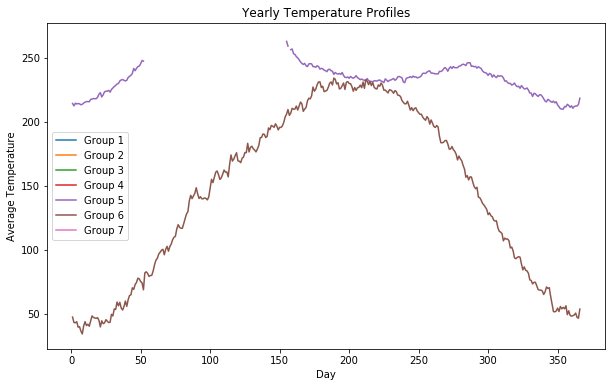

In [125]:
grouped_data = profile.groupby('group')['Values'].apply(lambda x: np.nanmean(np.vstack([np.nan_to_num(arr, nan=np.nan) for arr in x]), axis=0))
days = np.arange(1, 367)

plt.figure(figsize=(10, 6))
for i, group_data in enumerate(grouped_data):
    plt.plot(days, group_data, label=f'Group {i+1}')

plt.xlabel('Day')
plt.ylabel('Average Temperature')
plt.title('Yearly Temperature Profiles')
plt.legend()
plt.show()


In [77]:
grouped_data

group
0    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
1    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
2    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
3    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
4    [214.4, 212.5, 214.6, 214.0, 214.4, 214.1, 213...
5    [47.4, 43.12, 42.94, 43.8, 39.53, 39.88, 36.44...
6    [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...
Name: Values, dtype: object

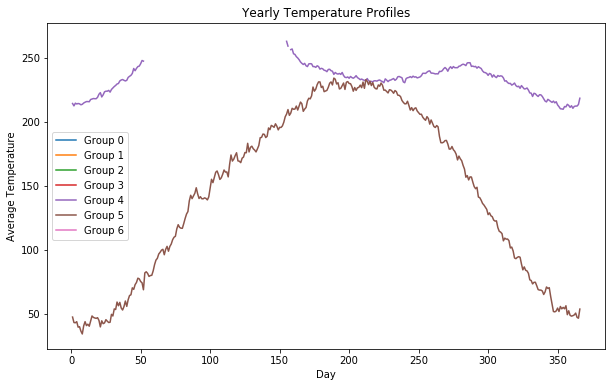

In [80]:
days = np.arange(1, 367)

plt.figure(figsize=(10, 6))
for i, group_data in enumerate(grouped_data):
    plt.plot(days, group_data, label=f'Group {i}')

plt.xlabel('Day')
plt.ylabel('Average Temperature')
plt.title('Yearly Temperature Profiles')
plt.legend()
plt.show()

In [158]:
# THIS IS JUST A TEMPLATE. COPY THE DICTIONARIES AND CHANGE THE VALUES. DO NOT CHANGE VARIABLE NAMES!
group_answer = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}
waveform_answer = {'A': 'a', 'B': 'b', 'C': 'c', 'D': 'd', 'E': 'e', 'F': 'f'}

###
### YOUR CODE HERE
###

group_answer = {'A': 3, 'B': 2, 'C': 1, 'D': 0, 'E': 6, 'F': 4}
waveform_answer = {'A': 'e', 'B': 'd', 'C': 'g', 'D': 'c', 'E': 'f', 'F': 'a'}

In [159]:
assert len(group_answer) == 6, 'group_answer should only have 6 keys/values'
assert len(waveform_answer) == 6, 'waveform_answer should only have 6 keys/values'

for region in ['A', 'B', 'C', 'D', 'E', 'F']:
    assert region in group_answer, f'Your group_answer is missing region {region}'
for region in ['A', 'B', 'C', 'D', 'E', 'F']:
    assert region in waveform_answer, f'Your waveform_answer is missing region {region}'

unique_group_answer = np.unique(list(group_answer.values()), return_counts=True)
unique_waveform_answer = np.unique(list(waveform_answer.values()), return_counts=True)
assert (unique_group_answer[1] == 1).all(), 'Your group_answer contains duplicate answers'
assert (unique_waveform_answer[1] == 1).all(), 'Your waveform_answer contains duplicate answers'

In [117]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [118]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [119]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [120]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [121]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [122]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [123]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [124]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [125]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [126]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [127]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [128]:
## Hidden test cases here
###
### AUTOGRADER TEST - DO NOT REMOVE
###
